# New York City Taxis Tips

On s'intéresse ici à la prédiction du montant de pourboires (tips) payé pour des courses de taxi à New-York. On dispose d'un jeu de données d'entraînement représentant 100 000 courses de taxis effectuées en janvier 2024 pour lesquelles le montant des pourboires est connu.

In [23]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab 
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# I. Les données

Les données d'entraînement et de test sont stockées dans le dossier ./data/ dans les fichiers train.csv et test.csv. Ces données sont ensuite chargées dans les DataFrames train_df et test_df.

In [4]:
import os

_REP_PATH_ = os.getcwd()

In [9]:
# Initialisation des DataFrames contenant les données

# DataFrame des données d'entrainement
train_df = pd.read_csv(_REP_PATH_+'/data/train.csv', index_col = 0)

# DataFrame des données de test
test_df = pd.read_csv(_REP_PATH_+'/data/test.csv', index_col = 0)


# Affichage des premiers individus des DataFrames
train_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
0,1,2024-01-15 20:37:28,2024-01-15 20:56:43,1.0,3.30,1.0,N,1,19.1,3.5,0.5,4.80,0.0,1.0,2.5,0.0,40.734576,-74.002875,40.768615,-73.965635
1,2,2024-01-25 19:41:24,2024-01-25 19:44:42,1.0,0.72,1.0,N,1,5.8,2.5,0.5,2.46,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.780436,-73.957012
2,2,2024-01-25 15:48:48,2024-01-25 16:24:23,2.0,7.45,1.0,N,1,38.7,0.0,0.5,3.00,0.0,1.0,2.5,0.0,40.717773,-74.007880,40.780436,-73.957012
3,2,2024-01-27 00:47:26,2024-01-27 00:55:55,1.0,1.53,1.0,N,1,10.0,1.0,0.5,2.25,0.0,1.0,2.5,0.0,40.720889,-73.996919,40.747746,-73.978492
4,2,2024-01-28 13:14:26,2024-01-28 13:22:34,1.0,1.53,1.0,N,1,10.0,0.0,0.5,3.50,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.747746,-73.978492


## Données d'entraînement vs données test

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627163 entries, 0 to 2627162
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   payment_type           int64         
 8   fare_amount            float64       
 9   extra                  float64       
 10  mta_tax                float64       
 11  tolls_amount           float64       
 12  improvement_surcharge  float64       
 13  congestion_surcharge   float64       
 14  Airport_fee            float64       
 15  PU_location_lat        float64       
 16  PU_location_lon        float64       
 17  DO_location_lat        float64       
 18  DO_location_lon       

In [13]:
train_df.describe() - test_df.describe()

,Airport_fee,DO_location_lat,DO_location_lon,PU_location_lat,PU_location_lon,RatecodeID,VendorID,congestion_surcharge,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,tip_amount,tolls_amount,trip_distance
count,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,NaN,-2.527163e+06,-2.527163e+06
mean,-1.683047e-03,6.649990e-07,1.322962e-05,7.895556e-05,-1.425363e-04,-2.287472e-02,2.163494e-04,2.124726e-03,-1.234212e-02,-4.554352e-02,-2.573317e-05,-1.529911e-04,-4.003920e-03,1.208485e-03,NaN,1.882941e-03,-1.144276e-02
std,-2.583026e-03,-6.199025e-05,9.511550e-05,3.874467e-05,-1.847739e-04,-1.158735e-01,-1.292599e-04,-3.697207e-03,-1.151490e-02,-1.049573e-01,1.110404e-03,7.520157e-04,-3.131846e-03,2.146457e-03,NaN,2.925993e-03,-1.194245e-02
min,0.000000e+00,3.194477e-03,4.585618e-02,1.782656e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
max,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.562997e-02,0.000000e+00,0.000000e+00,0.000000e+00,-2.500000e+00,-6.052000e+02,0.000000e+00,-3.500000e+00,-2.000000e+00,0.000000e+00,NaN,-4.620000e+01,-2.636000e+01


On note que les données d'entraînement et de test concernent le même mois. 

Les écart-types et moyennes sont proche pour les jeux de données, avec un écart inférieur à 0.1 pour chacune des variables.

## Correlation

In [20]:
correlation_matrix = train_df.drop(columns= ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag']).corr()

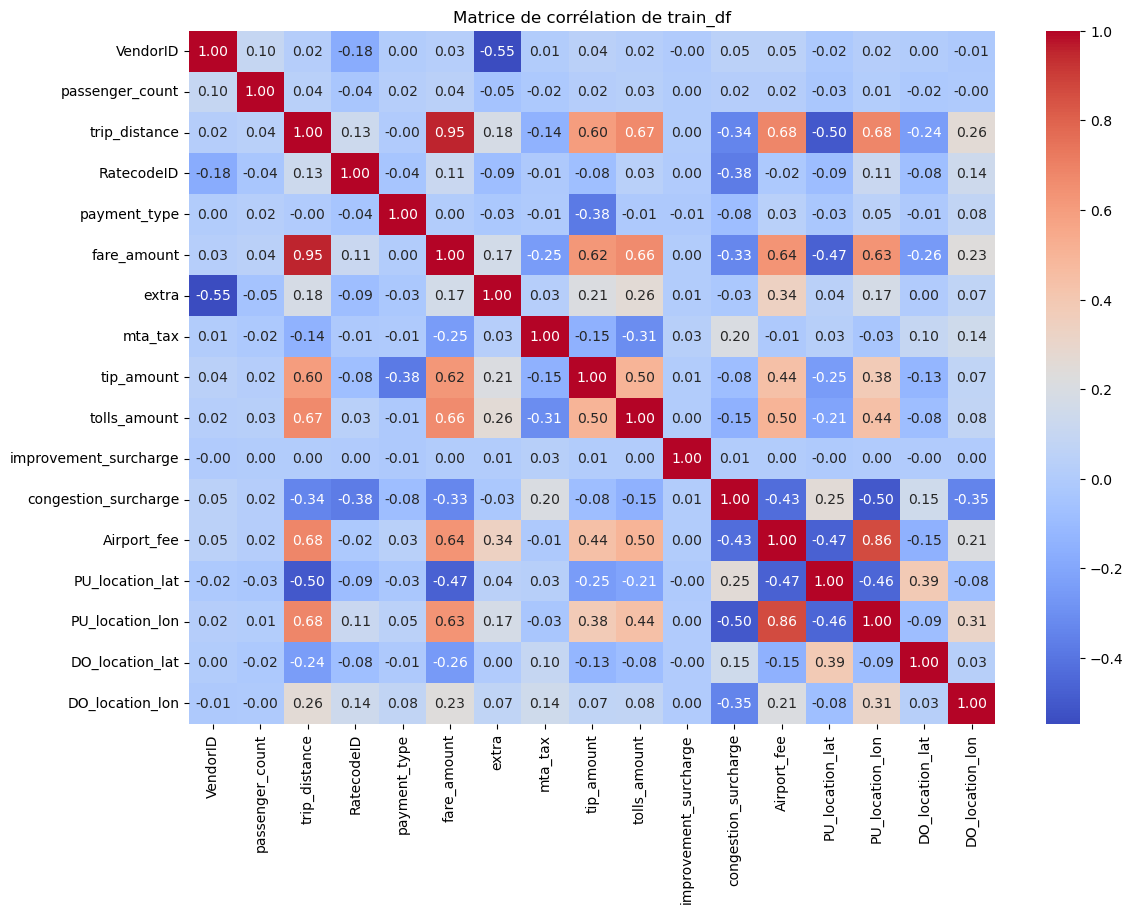

In [22]:


# Création de la heatmap
matplotlib.pylab.figure(figsize=(13,9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Afficher le graphique
plt.title("Matrice de corrélation de train_df")
plt.show()

On observe une forte corrélation entre les variables `trip_distance` et `fare_amount`. Cela était prévisible puisque les trajets plus longs coûtent plus cher. Nous allons tout de même conserver ces deux variables dans la suite. Les variables `PU_location_lon` et `Airport_fee` sont aussi fortement corrélées, ce qui confirme que la taxe d'aéroport concerne la localisation du départ de la course.

## Étude des données en ACP

In [24]:
scaler = StandardScaler()
X_ACP = train_df.drop(columns= ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag'])
X_ACP_standardized = scaler.fit_transform(X_ACP)

In [25]:
mypca = PCA(n_components= 5)

mypca.fit(X_ACP_standardized)

# Pourcentage de la variance expliquée par chacune des composantes sélectionnées.
print(mypca.singular_values_) # Valeurs de variance
print(mypca.explained_variance_ratio_) #  Pourcentages

# Résultats de l'ACP
data_sortie= mypca.fit_transform(X_ACP_standardized)

# Bruit estimé lié à la covariance
print(mypca.noise_variance_)

[697.7409729  406.24740688 399.72232436 356.8943033  338.55321207]
[0.28637792 0.09708056 0.09398702 0.07492561 0.06742252]
0.5386310708344757


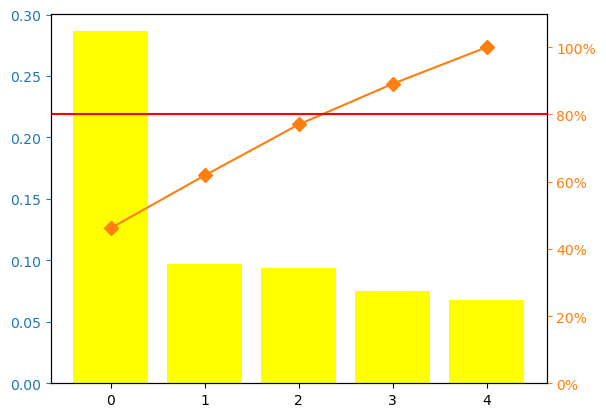

In [26]:
from matplotlib.ticker import PercentFormatter

def pareto(data) :

    y = list(data)
    x = range(len(data))
    
    ycum = np.cumsum(y)/sum(y)*100

    fig, ax = plt.subplots()
    ax.bar(x,y,color="yellow")
    ax2 = ax.twinx()
    ax2.plot(x,ycum, color="C1", marker="D", ms=7)
    ax2.axhline(y=80,color="r")
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")

    plt.ylim(0,110)
    plt.show()

pareto(mypca.explained_variance_ratio_)

Un diagramme de pareto permet de s'assurer que les composantes retenues retiendront bien la majorité de la variabilité. Pour qu'un pareto soir pertinaent, il ne fait pas fixer le nombre de composante retenues sinon on ignore volontairement une partie de la variance perdu. Mes 4 premières composantes absorbent bien la majorité de la variabilité.

In [27]:
loadings = mypca.components_.T * np.sqrt(mypca.explained_variance_)

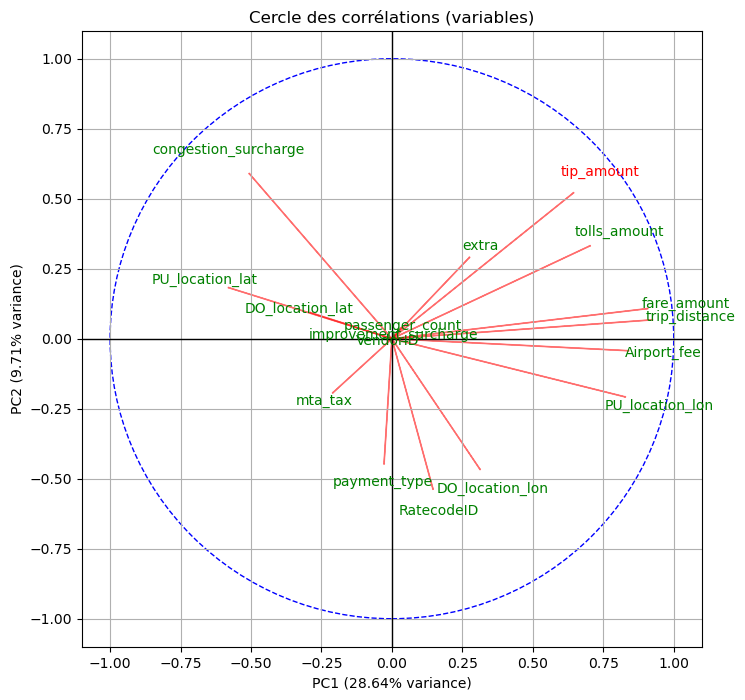

In [28]:
def plot_correlation_circle(loadings, labels, pca, axis):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    axe1, axe2 = axis

    # Définir un cercle de référence pour mieux visualiser
    circle = plt.Circle((0, 0), 1, color='b', fill=False, linestyle='--', linewidth=1)
    ax.add_artist(circle)

    # Tracer les flèches pour chaque variable
    for i in range(len(loadings)):
        plt.arrow(0, 0, loadings[i, axe1], loadings[i, axe2], color='r', alpha=0.5)
        if labels[i] == "tip_amount" :
            plt.text(loadings[i, axe1]*1.15, loadings[i, axe2]*1.15, labels[i], color='red', ha='center', va='center')
        else :
            plt.text(loadings[i, axe1]*1.15, loadings[i, axe2]*1.15, labels[i], color='g', ha='center', va='center')

    # Limites et étiquettes
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel(f"PC{axe1+1} ({pca.explained_variance_ratio_[axe1]*100:.2f}% variance)")
    plt.ylabel(f"PC{axe2+1} ({pca.explained_variance_ratio_[axe2]*100:.2f}% variance)")
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.grid()
    plt.title('Cercle des corrélations (variables)')
    plt.show()

# Tracer le cercle des variables dans le plan (0,1)
plot_correlation_circle(loadings, labels=X_ACP.columns, pca=mypca, axis = (0,1))

Les variables les mieux représentées sont `fare_amount`, `trip_distance`, `Airport_fee`, `PU_location_lon` et `tip_amount`. On retrouve les fortes corrélations déjà observée entre `trip_distance` et `fare_amount`, et entre `PU_location_lon` et `Airport_fee`. Sur le premier plan, la variable `tip_amount` que l'on cherche à estimer est pricnipalement corrélée à `extra` et `tolls_amount`, et anti-corrélée à `mta_tax`. Malheureusement, les variables `extra` et `mta_tax` sont mal représentées sur le premier plan.

## Encodage de certaines variables

In [29]:
train_df['store_and_fwd_flag'].value_counts()

N    99578
Y      422
Name: store_and_fwd_flag, dtype: int64

La variable `Store_and_fwd_flag` ne semble pas être la plus pertinente. Elle ne prend que 2 valeurs et 99.5% des individus sont `Non`. Il va être difficile d'en déterminer des patterns, mais nous décidons de l'encoder tout de même. 

In [32]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

le = LabelEncoder()
train_df['store_and_fwd_flag']=le.fit_transform(train_df['store_and_fwd_flag'])
train_df['store_and_fwd_flag'].value_counts()

0    99578
1      422
Name: store_and_fwd_flag, dtype: int64

In [37]:
train_df['RatecodeID'].value_counts()

1.0     95078
2.0      3439
99.0      968
3.0       262
5.0       235
4.0        18
Name: RatecodeID, dtype: int64

In [44]:
#Encoder 99 à 6 pour que nos modèles utilisant la distance donnent une mauvaise interpretabilité au modèle
train_df['RatecodeID'].replace(99., 6.)
train_df['RatecodeID'].value_counts()

1.0    95078
2.0     3439
6.0      968
3.0      262
5.0      235
4.0       18
Name: RatecodeID, dtype: int64

In [103]:
train_df['mta_tax'].value_counts()

0.5    99301
0.0      474
Name: mta_tax, dtype: int64

In [105]:
test_df['mta_tax'].value_counts()

0.5    2613827
0.0      13332
4.0          4
Name: mta_tax, dtype: int64

On observe la même propotions de valeurs égales à 0.5 (>95% environ). Cependant, la veleur 4 apparaît uniquement dans le jeu test. En vue de sa faible occurence, nosu décidons de ne pas modifier cette variables, en espérant que la valeur 4 ne soit pas trop génante pour généraliser le modèle.

In [110]:
train_df['congestion_surcharge'].value_counts()

2.5    93264
0.0     6511
Name: congestion_surcharge, dtype: int64

In [111]:
test_df['congestion_surcharge'].value_counts()

2.5    2451668
0.0     175493
1.0          2
Name: congestion_surcharge, dtype: int64

On observe le même phénomène que pour la variable `mta_tax`. Cependant, cette fois, on décide de supprimer la variable `congestion_surcharge` puisqu'elle est inversement lieé à la longitude, la latitude d'après nos informations https://www.nyc.gov/site/tlc/about/congestion-surcharge.page. 

In [ ]:
train_df = train_df.drop(columns=['congestion_surcharge'])

In [113]:
train_df['Airport_fee'].value_counts()

0.00    91752
1.75     8023
Name: Airport_fee, dtype: int64

In [114]:
test_df['Airport_fee'].value_counts()

0.00    2413176
1.75     213987
Name: Airport_fee, dtype: int64

Nous ne rencontrons pour l'instant pas de problème avec les aéroports. Nous essaierons de les localiser dans la suite.

## création de nouvelles variables

Nous allons créer une colonne qui distingue l'heure et le jour. Nous encodons les jours et jour+heure

In [36]:
train_df['pickup_day'] = train_df['tpep_pickup_datetime'].dt.day
train_df['pickup_hour'] = train_df['tpep_pickup_datetime'].dt.hour + train_df['tpep_pickup_datetime'].dt.minute / 60


train_df['dropoff_day'] = train_df['tpep_dropoff_datetime'].dt.day
train_df['dropoff_hour'] = train_df['tpep_dropoff_datetime'].dt.hour + train_df['tpep_dropoff_datetime'].dt.minute / 60

On crée une colonne `journey_time` qui contient le temps de trajet arrondi à la seconde près

In [46]:
train_df['tpep_pickup_datetime'] = pd.to_datetime(train_df['tpep_pickup_datetime'])
train_df['tpep_dropoff_datetime'] = pd.to_datetime(train_df['tpep_dropoff_datetime'])

train_df['journey_time'] = train_df['tpep_dropoff_datetime'] - train_df['tpep_pickup_datetime']
train_df['journey_time'] = train_df['journey_time'].apply(lambda x: x.total_seconds())


print(train_df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'journey_time']])

      tpep_pickup_datetime tpep_dropoff_datetime  journey_time
0      2024-01-15 20:37:28   2024-01-15 20:56:43        1155.0
1      2024-01-25 19:41:24   2024-01-25 19:44:42         198.0
2      2024-01-25 15:48:48   2024-01-25 16:24:23        2135.0
3      2024-01-27 00:47:26   2024-01-27 00:55:55         509.0
4      2024-01-28 13:14:26   2024-01-28 13:22:34         488.0
...                    ...                   ...           ...
99995  2024-01-19 09:12:12   2024-01-19 09:38:07        1555.0
99996  2024-01-25 00:07:40   2024-01-25 00:25:13        1053.0
99997  2024-01-08 09:27:23   2024-01-08 10:01:52        2069.0
99998  2024-01-06 18:42:49   2024-01-06 19:23:57        2468.0
99999  2024-01-25 22:43:34   2024-01-25 22:52:34         540.0

[100000 rows x 3 columns]


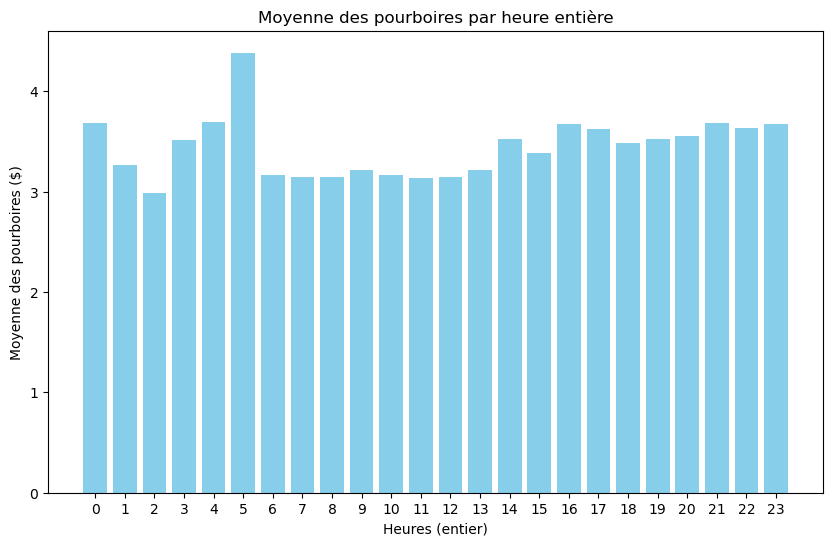

In [53]:
#Afficher la moyenne de tips_amount par heure au mois de janvier

# Créer une colonne avec les heures entières
train_df['pickup_hour_integer'] = train_df['pickup_hour'].astype(int)

average_tip_per_hour = train_df.groupby('pickup_hour_integer')['tip_amount'].mean().reset_index()
average_tip_per_hour.columns = ['hour', 'average_tip_amount']


#Barplot de la moyenne de tips_amount par heure au mois de janvier
plt.figure(figsize=(10, 6))
plt.bar(average_tip_per_hour['hour'], average_tip_per_hour['average_tip_amount'], color='skyblue')


plt.xlabel('Heures (entier)')
plt.ylabel('Moyenne des pourboires ($)')
plt.title('Moyenne des pourboires par heure entière')
plt.xticks(average_tip_per_hour['hour'])  


plt.show()

On constate qu'entre 14h et 5h du matin, le montant des pourboirs est plus éléevé.

Le temps de trajet moyen par jour a peut-être une influence sur le pourboire.
Conforté par cet article : https://www.20minutes.fr/monde/4071075-20240117-new-york-sous-neige-apres-plus-sept-cent-jours-flocons et après un regard sur les données météo à New York en janvier 2024, nous avons constaté une météo enneigée les 16, 18 et 19 janvier 2024 et le 29 janvier 2024 (pas mal de pluie). Peut-être que les chauffeurs ont eu une reconnaissance plus élevée venant de leurs clients matérialisée par les pourboires.

In [55]:
train_df['time_per_km'] = train_df['journey_time'] / train_df['trip_distance']

# Groupement par jour pour calculer la moyenne du temps par km et la moyenne des pourboires
daily_stats = train_df.groupby('pickup_day').agg(
    avg_time_per_km=('time_per_km', 'mean'),
    avg_tip_amount=('tip_amount', 'mean')
).reset_index()

print(daily_stats)

    pickup_day  avg_time_per_km  avg_tip_amount
0            1       457.203362        3.650987
1            2       401.389763        3.552927
2            3       383.855152        3.419071
3            4       425.905562        3.293235
4            5       424.420956        3.293313
5            6       425.212953        2.990557
6            7       362.704514        3.446052
7            8       442.350723        3.414010
8            9       493.533614        3.244381
9           10       423.245247        3.461559
10          11       432.432076        3.487292
11          12       416.280875        3.437784
12          13       457.070304        3.278045
13          14       413.047322        3.500988
14          15       386.161299        3.676487
15          16       509.779140        3.694975
16          17       468.722497        3.537019
17          18       516.581311        3.514315
18          19       440.334534        3.244822
19          20       450.261330        3

Les valeurs de distance moyen sont dominés par le 1e, le 16,17,18,24 et 27 janvier 2024. Les valeurs de pourboire moyen sont dominés par le 1e, le 15,16 et le 29 janvier 2024. Le 1e janvier correspond au jour de l'an (qui provoque un élan de générosité). Le 16,17 et 18 correspondent aux jours d'enneigement.


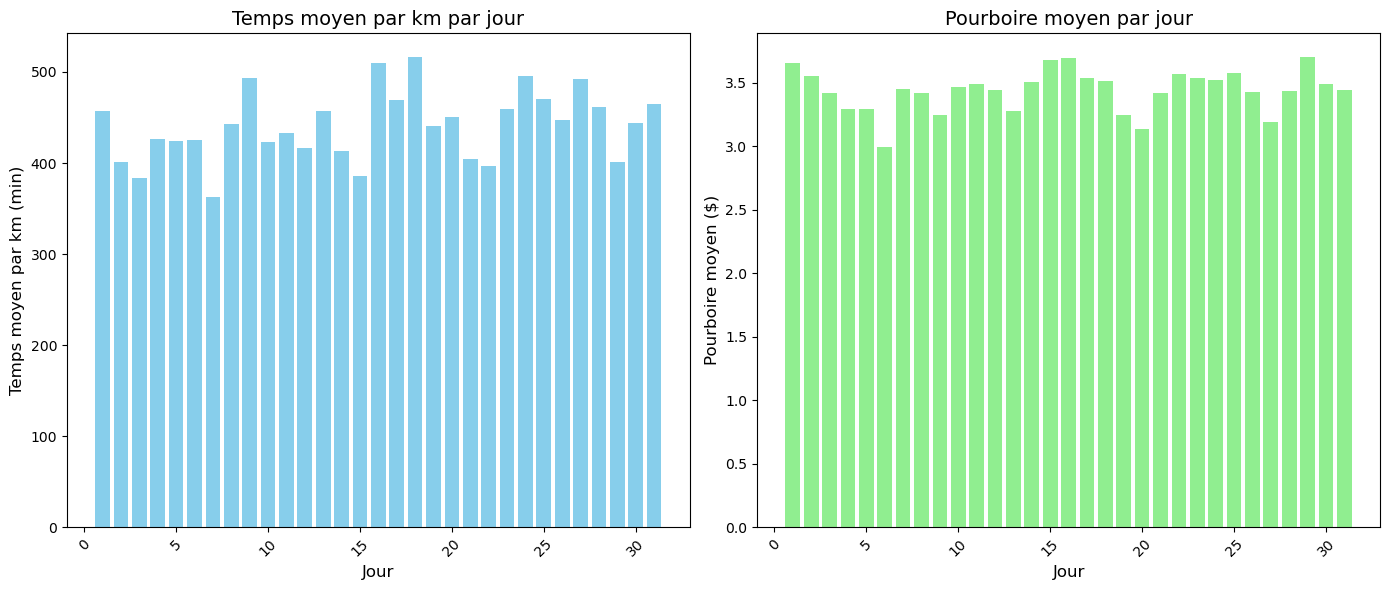

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Temps moyen par kilomètre par jour
ax1.bar(daily_stats['pickup_day'], daily_stats['avg_time_per_km'], color='skyblue')
ax1.set_title('Temps moyen par km par jour', fontsize=14)
ax1.set_xlabel('Jour', fontsize=12)
ax1.set_ylabel('Temps moyen par km (min)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Pourboire moyen par jour
ax2.bar(daily_stats['pickup_day'], daily_stats['avg_tip_amount'], color='lightgreen')
ax2.set_title('Pourboire moyen par jour', fontsize=14)
ax2.set_xlabel('Jour', fontsize=12)
ax2.set_ylabel('Pourboire moyen ($)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

# on a constaté que la météo enneigée les 16, 18 et 19 janvier 2024 se répercute sur le temps moyen par km 
# et la météo pluvieuse du 27 janvier aussi,

#En revanche difficle d'établir un lien de cause à effet sur le montant du pourboire.

#La date a en revanche une influence sur le montant du pourboire

In [59]:
#Regarder l'influence des périodes de la journée sur les pourboires

def get_pickup_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon_part1'
    elif 16 <= hour <20:
        return 'Afternoon_part2'
    elif 20 <= hour <=23.99:
        return 'Evening'
    else:
        return 'Night'
        
train_df['pickup_period'] = train_df['pickup_hour'].apply(get_pickup_period)

print(train_df[['pickup_hour', 'pickup_period']].head())

   pickup_hour    pickup_period
0    20.616667          Evening
1    19.683333  Afternoon_part2
2    15.800000  Afternoon_part1
3     0.783333            Night
4    13.233333  Afternoon_part1


In [60]:
train_df['pickup_period'].value_counts()

Afternoon_part2    26617
Afternoon_part1    24458
Morning            22318
Evening            19321
Night               7286
Name: pickup_period, dtype: int64

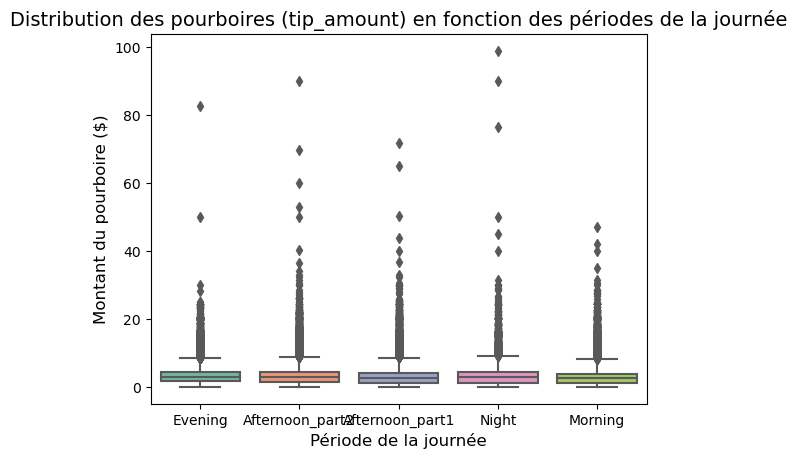

In [63]:
# Créer un boxplot pour visualiser 'tip_amount' en fonction de 'pickup_period'

sns.boxplot(x='pickup_period', y='tip_amount', data=train_df, palette='Set2')
plt.title('Distribution des pourboires (tip_amount) en fonction des périodes de la journée', fontsize=14)
plt.xlabel('Période de la journée', fontsize=12)
plt.ylabel('Montant du pourboire ($)', fontsize=12)


plt.show()

Des valeurs extremes de pourboires sont associées à la Nuit et au soir, ce qui confirme notre intuition.

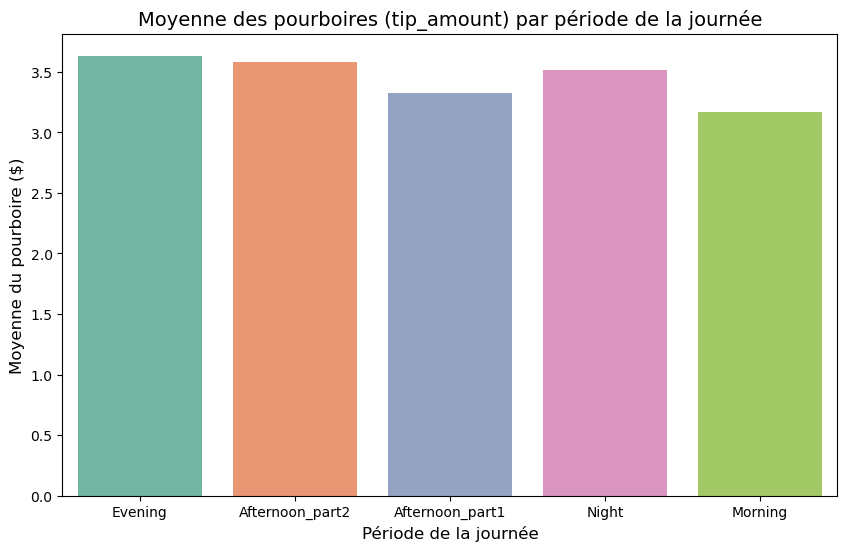

In [65]:
plt.figure(figsize=(10, 6))
sns.barplot(x='pickup_period', y='tip_amount', data=train_df, estimator='mean', errorbar=None, palette='Set2') #mean


plt.title('Moyenne des pourboires (tip_amount) par période de la journée', fontsize=14)
plt.xlabel('Période de la journée', fontsize=12)
plt.ylabel('Moyenne du pourboire ($)', fontsize=12)
plt.show()


Bien que la nuit fasse apparaître davantage de valeurs extrêmes, on ne distingue pas de différence significative au niveau de la moyenne. Au vu de ces deux plots, on a peu de différence significative des moyennes et médianes selon la période
mais des valeurs extrêmes plus fréquentes pour Evening et Night. Nous choisissons donc simplement d'encoder manuellement `pickup_period` selon l'ordre croissant des valeurs moyennes.

In [67]:
# Encoder manuellement "pickup_period" selon l'ordre croissant des valeurs moyennes 
train_df['pickup_period_encoded'] = train_df['pickup_period'].replace({
    'Morning': 0,        # 
    'Afternoon_part1': 1, 
    'Afternoon_part2': 2, # 
    'Evening': 3,       # 
    'Night': 4          # 
})

print(train_df[['pickup_period', 'pickup_period_encoded']].head())

     pickup_period  pickup_period_encoded
0          Evening                      3
1  Afternoon_part2                      2
2  Afternoon_part1                      1
3            Night                      4
4  Afternoon_part1                      1


In [70]:
# On retire les colonnes créées pour obtenir la variable 'pickup_period_encoded'
train_df.drop(columns=['pickup_hour_integer','time_per_km', 'pickup_period'],inplace=True)
train_df.drop(columns=['tpep_pickup_datetime','tpep_dropoff_datetime'],inplace=True)

## Suppression des lignes aberrantes

<Axes: xlabel='trip_distance', ylabel='journey_time'>

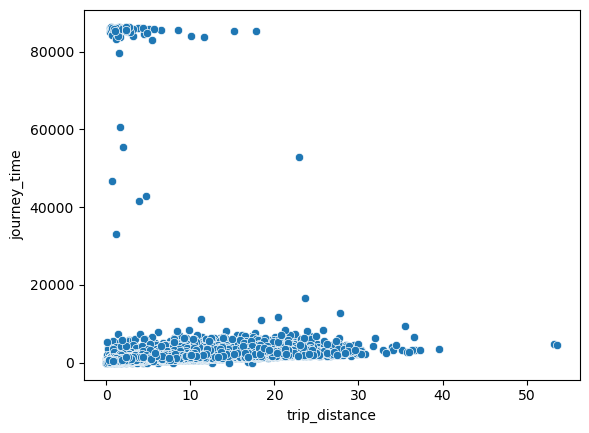

In [71]:
sns.scatterplot(data=train_df, x="trip_distance", y="journey_time")

In [74]:
long_max_trajet_10h = train_df[train_df['journey_time']>36000]['trip_distance'].max() 
print("longueur du plus long trajet dont la durée dépasse 10 heures : " + str(long_max_trajet_10h) + " km")

longueur du plus long trajet dont la durée dépasse 10 heures : 22.96 km


En vue des valeurs abberantes que peut prendre la variable `journey_time`, notamment lorsque la distance parcourue n'est pas très élevée, nous décidons de supprimer les trajets dépassant les 600 minutes des données d'entraînement. En effet, il semble impossible de parcourir seulement 23km en 10 heures.

In [75]:
#On supprime tous les trajets à plus de 600 min. 
train_df = train_df[train_df['journey_time']<36000]

<Axes: xlabel='journey_time', ylabel='fare_amount'>

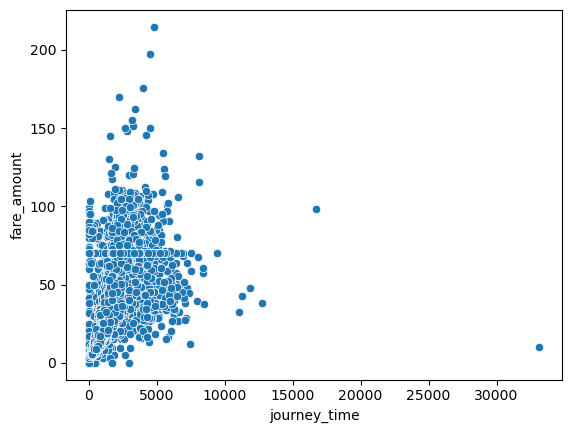

In [77]:
sns.scatterplot(data=train_df, x="journey_time", y="fare_amount")

Une valeur de `journey_time` dépassant les 500 min (6h20min) avec un tarif hors pourboir si faible semble peu probable puisque  le prix est calculé en fonction de la distance et de la durée. Nous décidons donc de supprimer cette ligne.

In [79]:
train_df = train_df[train_df['journey_time']<30000]

On sépare les trajets dont la destination est Manhattan

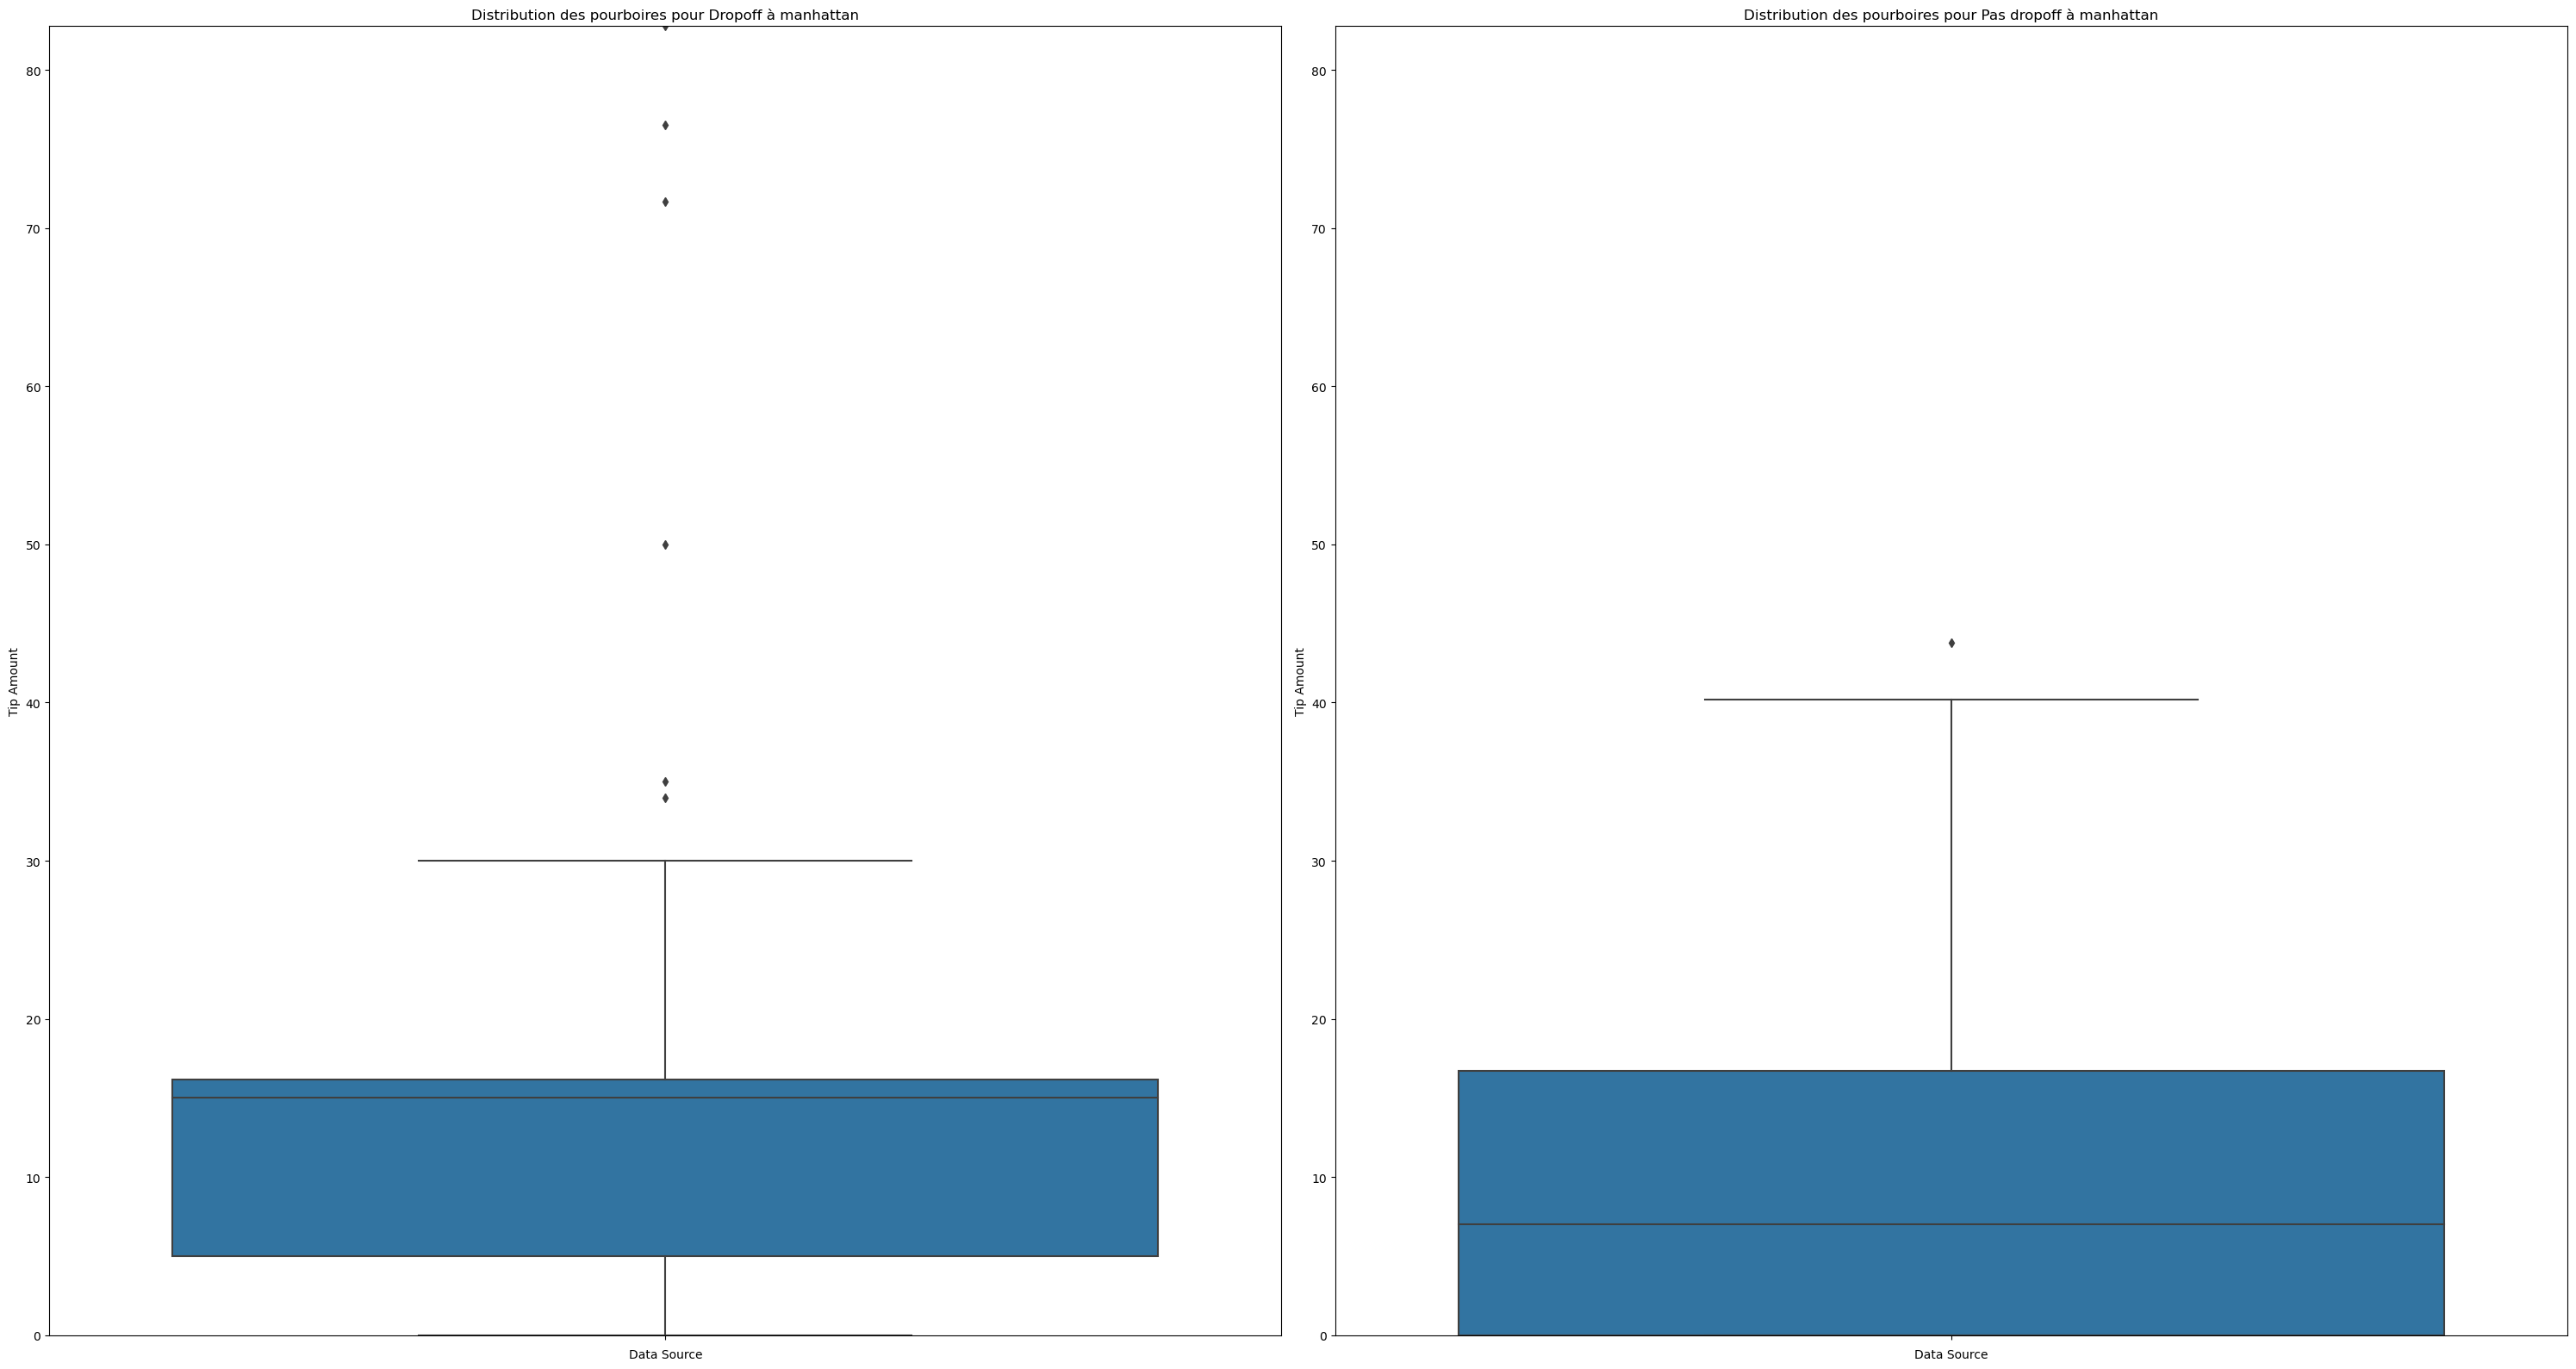

In [80]:
manhattan_trajet=train_df[train_df['RatecodeID']==2]
no_manhattan_trajet=train_df[train_df['RatecodeID']==5]


fig, axes = plt.subplots(1, 2, figsize=(30, 16))
axes = axes.flatten()

# Liste des DataFrames à comparer
data_cmp = [manhattan_trajet,no_manhattan_trajet,train_df]

# Créer des boxplots pour chaque DataFrame
for i, ax in enumerate(axes):
    sns.boxplot(y='tip_amount', data=data_cmp[i], ax=ax)
    ax.set_title('Distribution des pourboires pour ' + (['Dropoff à manhattan', 'Pas dropoff à manhattan'][i]))
    ax.set_ylabel('Tip Amount')
    ax.set_xlabel('Data Source')

# Définir des limites communes pour l'axe des ordonnées
y_min = min(data_cmp[1]['tip_amount'].min(), data_cmp[0]['tip_amount'].min())
y_max = max(data_cmp[1]['tip_amount'].max(), data_cmp[0]['tip_amount'].max())
for ax in axes:
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

In [81]:
no_manhattan_trajet['tip_amount'].mean()

8.856127659574469

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

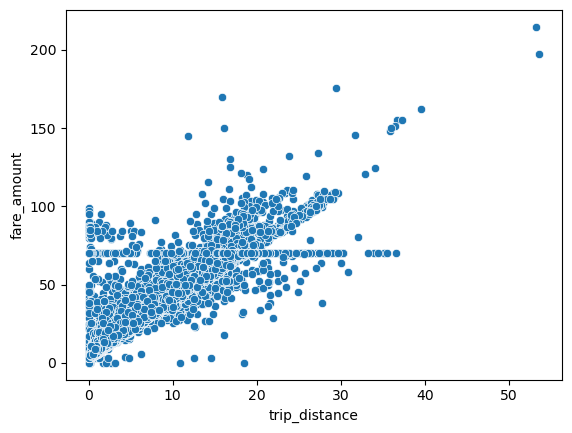

In [83]:
sns.scatterplot(data=train_df, x="trip_distance", y="fare_amount")

On a qqch d'à peu près linéaires. Nous ne supprimons rien de cela, mais on remarque des valeurs à 0 très elevés.

On supprime ceux qui ont payé moins de 3 dollars et on passé plus de 1 minutes 15. Cela parait peu commun d'après l'article https://www.nyc.gov/site/tlc/passengers/taxi-fare.page. Le reste peut-être acceptable en raison de faveur (circonsrtances exceptionnelles)

In [84]:
train_df = train_df[(train_df['fare_amount'] > 3.0) | (train_df['journey_time'] < 75.0)]

In [86]:
train_df[train_df['journey_time']<60]

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,...,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,pickup_day,pickup_hour,dropoff_day,dropoff_hour,journey_time,pickup_period_encoded
2471,2,1.0,0.05,1.0,0,2,3.00,1.0,0.5,0.00,...,40.748497,-73.992438,40.742279,-73.996971,13,5.416667,13,5.433333,28.0,4
2861,2,1.0,0.23,1.0,0,2,3.00,7.5,0.5,0.00,...,40.763352,-73.868395,40.774376,-73.873628,17,19.483333,17,19.500000,42.0,2
2910,2,1.0,0.17,5.0,0,1,89.78,0.0,0.0,24.43,...,40.646985,-73.786530,40.646985,-73.786530,29,10.016667,29,10.033333,16.0,0
3454,2,1.0,0.05,1.0,0,2,3.00,1.0,0.5,0.00,...,40.646985,-73.786530,40.646985,-73.786530,14,23.283333,14,23.300000,51.0,3
3843,1,1.0,0.30,1.0,0,1,3.70,2.5,0.5,1.50,...,40.766948,-73.959635,40.766948,-73.959635,4,6.516667,4,6.533333,53.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99071,2,1.0,0.02,2.0,0,4,70.00,0.0,0.5,0.00,...,40.740337,-73.990458,40.736824,-73.984052,13,14.633333,13,14.633333,6.0,1
99364,1,1.0,14.60,1.0,0,1,3.00,0.0,0.5,0.90,...,40.646985,-73.786530,40.646985,-73.786530,20,6.566667,20,6.566667,11.0,0
99554,2,1.0,0.10,1.0,0,2,3.00,1.0,0.5,0.00,...,40.646985,-73.786530,40.646985,-73.786530,25,22.550000,25,22.566667,49.0,3
99595,2,1.0,0.02,1.0,0,2,3.00,0.0,0.5,0.00,...,40.763352,-73.868395,40.763352,-73.868395,21,12.733333,21,12.733333,28.0,1


<Axes: xlabel='trip_distance', ylabel='fare_amount'>

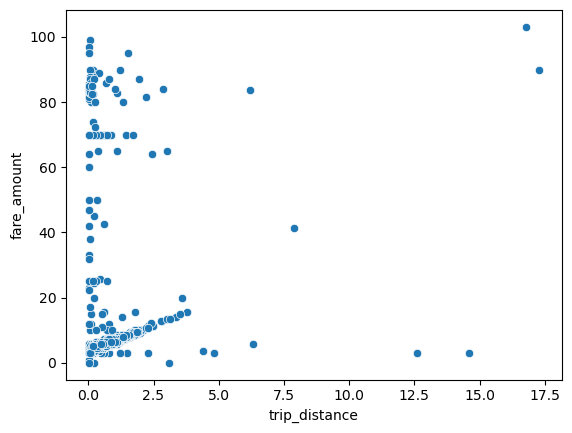

In [87]:
sns.scatterplot(data=train_df[train_df['journey_time']<300], x="trip_distance", y="fare_amount")

On supprime grossièrement ceux qui ont fait moins de 5 km, 5 min et qui payent plus de 40 dollars. 

In [88]:
train_df = train_df[(train_df['fare_amount'] < 40.0) | (train_df['trip_distance'] > 5.0) | (train_df['journey_time']>=300)]

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

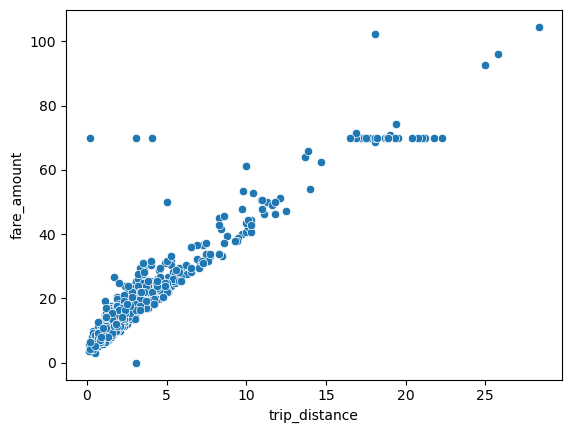

In [89]:
sns.scatterplot(data=train_df[train_df['passenger_count']==0], x="trip_distance", y="fare_amount")

In [90]:
train_df[(train_df['passenger_count']==0) & (train_df['fare_amount']>60) & (train_df['trip_distance']<5)]

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,...,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,pickup_day,pickup_hour,dropoff_day,dropoff_hour,journey_time,pickup_period_encoded
49526,1,0.0,0.2,2.0,0,2,70.0,2.50,0.5,0.0,...,40.748497,-73.992438,40.753513,-73.988787,18,15.950000,18,16.066667,371.0,1
87795,1,0.0,4.1,2.0,0,2,70.0,1.75,0.5,0.0,...,40.646985,-73.786530,40.646985,-73.786530,14,22.133333,14,22.333333,707.0,3
95350,1,0.0,3.1,2.0,0,4,70.0,5.00,0.5,0.0,...,40.809457,-73.961764,40.809457,-73.961764,31,16.683333,31,17.166667,1718.0,2


Les 3 points en haut nous intriguent. Les deux derniers indiquent une distance de 3.1 et 4.1 mais même localisation du pickup et dropoff. Le premier est 0.2 km , zeros passager et 70 euros de payé. On supprime les trois. On souhaitait initialement supprimer tout ceux qui sont à zero passager mais dans le X_test , il y en a. On décide donc d'entrainer notre modèle à rencontrer ce pattern.

In [ ]:
train_df.drop([49526,87795,95350],axis=0,inplace=True)

## Valeurs extrêmes de pourboir 

<Axes: ylabel='tip_amount'>

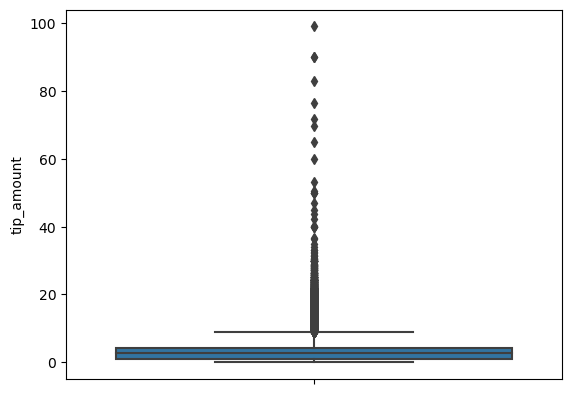

In [93]:
sns.boxplot(data=train_df, y="tip_amount")

In [94]:
train_df[train_df['tip_amount']>=50]

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,...,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,pickup_day,pickup_hour,dropoff_day,dropoff_hour,journey_time,pickup_period_encoded
2705,2,3.0,1.11,1.0,0,1,10.7,2.5,0.5,69.76,...,40.748575,-73.985156,40.736824,-73.984052,5,16.983333,5,17.150000,598.0,2
20106,2,3.0,6.44,1.0,0,1,33.1,1.0,0.5,50.00,...,40.734576,-74.002875,40.797962,-73.968168,19,2.566667,19,3.066667,1765.0,4
21236,2,1.0,12.27,1.0,0,1,47.1,5.0,0.5,65.00,...,40.774376,-73.873628,40.867682,-73.890184,6,15.366667,6,15.750000,1382.0,1
22259,2,4.0,53.64,1.0,0,1,197.6,0.0,0.5,50.40,...,40.780436,-73.957012,40.780436,-73.957012,8,14.250000,8,15.500000,4538.0,1
23377,2,1.0,18.49,2.0,0,1,70.0,0.0,0.5,71.70,...,40.646985,-73.786530,40.726290,-74.007486,14,14.916667,14,15.766667,3006.0,1
26513,2,1.0,2.24,1.0,0,1,12.8,1.0,0.5,90.00,...,40.735035,-74.008984,40.748575,-73.985156,27,3.466667,27,3.650000,627.0,4
31608,2,1.0,1.84,1.0,0,1,9.3,1.0,0.5,99.00,...,40.735035,-74.008984,40.748575,-73.985156,29,3.350000,29,3.450000,349.0,4
32320,2,1.0,3.06,1.0,0,1,19.1,0.0,0.5,90.00,...,40.726290,-74.007486,40.766238,-73.995135,14,19.816667,14,20.100000,1021.0,2
35923,2,1.0,17.39,2.0,0,1,70.0,0.0,0.5,82.77,...,40.646985,-73.786530,40.753513,-73.988787,2,21.766667,2,22.433333,2380.0,3
46555,2,1.0,18.34,2.0,0,1,70.0,0.0,0.5,50.00,...,40.646985,-73.786530,40.748427,-73.999918,15,23.933333,16,0.850000,3330.0,3


In [95]:
train_df.drop(columns=['VendorID'],inplace=True)

On supprime 3 lignes pour les raisons suivantes :
- Des valeurs aberrantes en termes de pourboire par rapport à la distance parcourue et au temps de trajet
- Toutes ces valeurs aberrantes sont asssociés au VendorID qui vaut 2--> Peut-être une surinterprétation du modèle
- Paient des prix plutot raisonnannles mais leur valeur de pourboire..

In [96]:
train_df.drop([31608,32320,26513],axis=0,inplace=True) 

In [97]:
train_df.shape[0]

99782

In [98]:
train_df[(train_df['journey_time']<60) & (train_df['trip_distance']>0.2)]

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,pickup_day,pickup_hour,dropoff_day,dropoff_hour,journey_time,pickup_period_encoded
2861,1.0,0.23,1.0,0,2,3.0,7.50,0.5,0.00,0.00,...,40.763352,-73.868395,40.774376,-73.873628,17,19.483333,17,19.500000,42.0,2
3843,1.0,0.30,1.0,0,1,3.7,2.50,0.5,1.50,0.00,...,40.766948,-73.959635,40.766948,-73.959635,4,6.516667,4,6.533333,53.0,0
3912,1.0,0.34,1.0,0,2,3.7,0.00,0.5,0.00,0.00,...,40.748575,-73.985156,40.747746,-73.978492,27,12.183333,27,12.200000,50.0,1
7741,1.0,0.25,1.0,0,1,3.7,0.00,0.5,1.54,0.00,...,40.780436,-73.957012,40.782477,-73.965555,8,10.750000,8,10.766667,51.0,0
10204,1.0,0.42,1.0,0,2,4.4,1.00,0.5,0.00,0.00,...,40.778766,-73.951010,40.766948,-73.959635,14,2.800000,14,2.816667,56.0,4
15050,1.0,0.31,1.0,0,2,3.7,1.00,0.5,0.00,13.88,...,40.600324,-74.071770,40.571769,-74.105019,17,1.116667,17,1.116667,29.0,4
15409,1.0,0.22,1.0,0,1,3.7,2.50,0.5,2.00,0.00,...,40.780436,-73.957012,40.780436,-73.957012,10,17.783333,10,17.800000,58.0,2
16692,1.0,0.70,1.0,0,1,5.8,2.50,0.5,3.69,0.00,...,40.748427,-73.999918,40.748427,-73.999918,23,19.466667,23,19.466667,11.0,2
19057,0.0,3.10,5.0,0,4,0.0,0.00,0.0,0.00,0.00,...,40.801169,-73.937346,40.801169,-73.937346,27,13.500000,27,13.516667,35.0,1
19421,1.0,0.21,1.0,0,2,3.7,0.00,0.5,0.00,0.00,...,40.782477,-73.965555,40.783961,-73.978632,28,10.183333,28,10.200000,52.0,0


In [ ]:
#On supprime ceux qui ont fait plus de 4 km
train_df.drop([97183,73337,99364],axis=0,inplace=True)

In [101]:
train_df[(train_df['journey_time']<300) & (train_df['trip_distance']>5) ]
#12.6km en 35 secondes et 16.8 km en 95 secondes. On supprimee

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,pickup_day,pickup_hour,dropoff_day,dropoff_hour,journey_time,pickup_period_encoded
39975,1.0,6.3,1.0,0,1,5.80,3.5,0.5,2.15,0.00,...,40.766948,-73.959635,40.756729,-73.965146,3,21.500000,3,21.566667,247.0,3
43380,1.0,12.6,1.0,0,3,3.00,3.5,0.5,0.00,0.00,...,40.775965,-73.987646,40.775965,-73.987646,29,2.333333,29,2.350000,32.0,4
56325,1.0,7.9,6.0,0,1,41.50,0.0,0.5,0.00,6.94,...,40.721432,-73.847669,40.812074,-73.885537,25,11.383333,25,11.400000,14.0,0
62937,1.0,16.8,5.0,0,1,103.11,7.5,0.5,0.00,6.94,...,40.646985,-73.786530,40.646985,-73.786530,31,17.516667,31,17.550000,95.0,2
70117,1.0,6.2,5.0,0,1,83.80,0.0,0.0,16.95,0.00,...,40.758028,-73.977698,40.758028,-73.977698,14,17.383333,14,17.400000,51.0,2


In [102]:
train_df.drop([62937,43380,70117,56325],axis=0,inplace=True)

## Localisations de prise en charge et fin de charge des clients

Dans la suite, nous allons nous concentrer davantage sur les localisations de prise et de fin de charge du client. Afin de potentiellement ajouter des variables ou potentielemment en retirer en espérant que certaines localisations induisent des valeurs de pourboire elevées ou faibles.

In [130]:
train_df_non_zero = train_df[train_df["tip_amount"]>0]

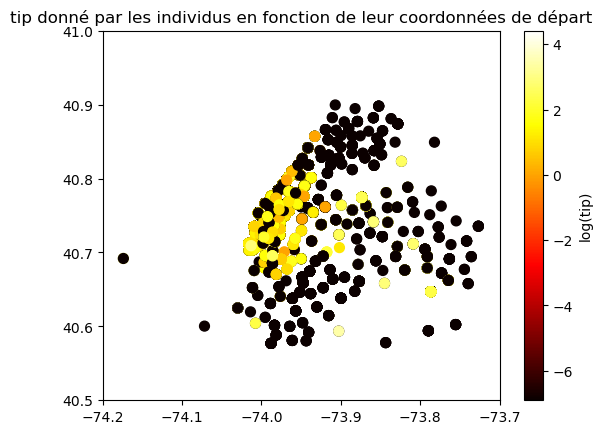

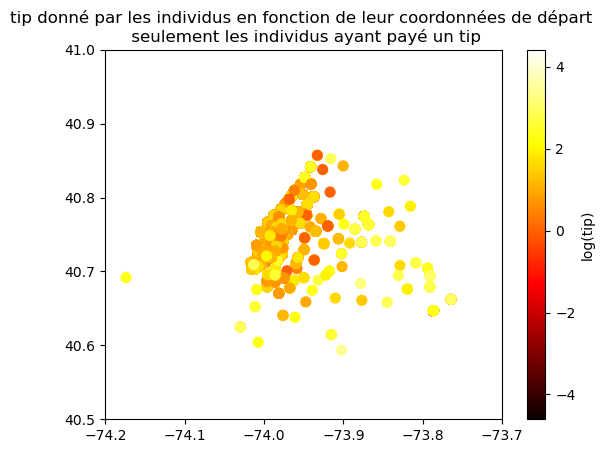

In [133]:
scatter = plt.scatter(train_df['PU_location_lon'], train_df['PU_location_lat'], c=np.log(train_df['tip_amount']+0.001), cmap='hot', s=50)
cbar = plt.colorbar(scatter, label='log(tip)')
plt.xlim([-74.2,-73.7])
plt.ylim([40.5,41.])
plt.title("tip donné par les individus en fonction de leur coordonnées de départ")
plt.show()

scatter = plt.scatter(train_df_non_zero['PU_location_lon'], train_df_non_zero['PU_location_lat'], c=np.log(train_df_non_zero['tip_amount']), cmap='hot', s=50)
cbar = plt.colorbar(scatter, label='log(tip)')
plt.xlim([-74.2,-73.7])
plt.ylim([40.5,41.])
plt.title("tip donné par les individus en fonction de leur coordonnées de départ \n seulement les individus ayant payé un tip")
plt.show()

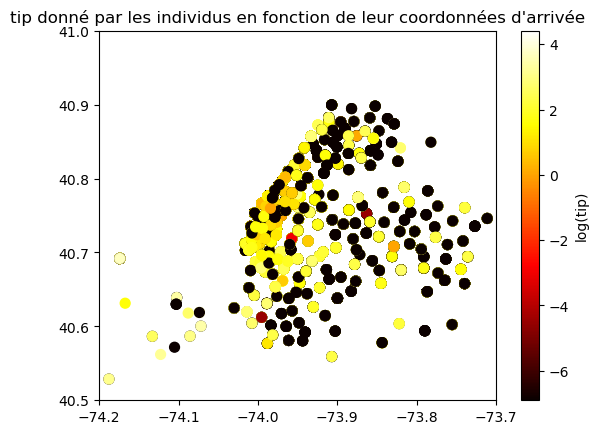

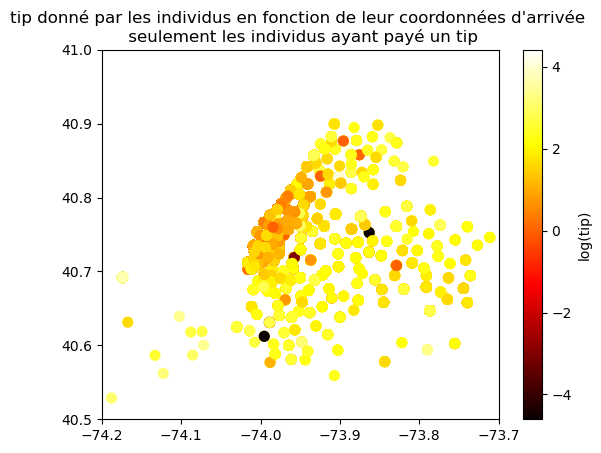

In [134]:
scatter = plt.scatter(train_df['DO_location_lon'], train_df['DO_location_lat'], c=np.log(train_df['tip_amount']+0.001), cmap='hot', s=50)
cbar = plt.colorbar(scatter, label='log(tip)')
plt.xlim([-74.2,-73.7])
plt.ylim([40.5,41.])
plt.title("tip donné par les individus en fonction de leur coordonnées d'arrivée")
plt.show()

scatter = plt.scatter(train_df_non_zero['DO_location_lon'], train_df_non_zero['DO_location_lat'], c=np.log(train_df_non_zero['tip_amount']), cmap='hot', s=50)
cbar = plt.colorbar(scatter, label='log(tip)')
plt.xlim([-74.2,-73.7])
plt.ylim([40.5,41.])
plt.title("tip donné par les individus en fonction de leur coordonnées d'arrivée \n seulement les individus ayant payé un tip")
plt.show()

On observe des trajets sans pourboirs répartis sur l'ensemble de la carte, et une forte concentration de pourboir important à l'intérieur d'une ellipse. Ce constat va nous encorager essayer des méthodes non linéaires pour les prédictions, et nous encorage à localiser spécifiquement les aéroports et autres lieux d'intéret.

In [118]:
# pip install geopy geozone geodatasets
# pip install folium matplotlib mapclassify

SyntaxError: invalid syntax (356509843.py, line 1)

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# les trajets concernées par les "Airport fees"
pu_location = train_df[train_df['Airport_fee'] != 0.0][['PU_location_lat', 'PU_location_lon']]
do_location = train_df[train_df['Airport_fee'] != 0.0][['DO_location_lat', 'DO_location_lon']]


geometry_pu = [Point(xy) for xy in zip(pu_location['PU_location_lon'], pu_location['PU_location_lat'])]
geometry_do = [Point(xy) for xy in zip(do_location['DO_location_lon'], do_location['DO_location_lat'])]


gdf_pu = gpd.GeoDataFrame(pu_location, geometry=geometry_pu, crs="EPSG:4326")
gdf_do = gpd.GeoDataFrame(do_location, geometry=geometry_do, crs="EPSG:4326")


gdf_pu.explore()


#Il y a trois aéroports 

In [ ]:
gdf_do.explore()

In [123]:
pu_location.value_counts()

#Parmi les 3 premiers, on a 2 aéoports : JFK et la Guardia

PU_location_lat  PU_location_lon
40.646985        -73.786530         4571
40.774376        -73.873628         3063
40.763352        -73.868395          375
40.740674        -73.840865            4
40.662186        -73.764505            1
40.678953        -73.790987            1
40.694428        -73.790965            1
40.723995        -73.902331            1
40.726155        -73.863338            1
40.745379        -73.948892            1
40.749914        -73.970443            1
40.757312        -73.885317            1
40.775932        -73.946510            1
40.788193        -73.815657            1
dtype: int64

In [125]:
do_location.value_counts()

# Parmi les 3 premiers, 2 endroits non loins de Times Square, on a l'Empire state building, d'après nos informations.
#Des endroits plus prisés...mais sont-elles liées à des pourboires plus élevés?

DO_location_lat  DO_location_lon
40.759818        -73.984197         423
40.758028        -73.977698         230
40.748575        -73.985156         199
40.762253        -73.989845         197
40.756688        -73.972356         164
                                   ... 
40.778559        -73.923086           1
40.561994        -74.122583           1
40.661622        -73.968914           1
40.852521        -73.915976           1
40.528686        -74.187679           1
Length: 235, dtype: int64

New York compte 3 aéroports
Concernant l'Airport fee, on remarque que parmi les trajets ayant une Airport_fee
La Guardia est la 2e localisation la plus relevée parmi les "pickup" (<5% du total)
Le JFK Airport est la 1e localisation la plus relevée parmi les "pickup" (>25% du total)


Cependant, cela dénote avec ce qu'on a obtenu comme information ici :https://www.nyc.gov/site/tlc/passengers/taxi-fare.page
Apparemment les "Airport_fee" concernent ceux qui démarrent ou terminent leur trajet à un aéroport, ce qui n'est pas le cas.
Quid de cette variable. On remarque que des trajets concernant l'Airport fee n'ont pas d'aéroport comme point de départ ni d'arrivée. On ne peut donc résumer l'information "Airport_fee" par les données de localisation du "Dropout" ni du "Pickup"

Les trajets où l'`Airport_fee` apparait ne sont pas tous liés à des trajets dont la destination ou le départ est un aéroport 

Cependant, Les trajets contenant un `Airport_fee` nous montrent que des lieux de pickup et de dropoff les plus fréquentés sont les aéroports et lieux historiques (Times Square, Empire State Building). L'implication de ces lieux entrainent-ils un pourboire plus éleveé ?


In [ ]:
#Les trajets non concernés par la 'congestion_surcharge', payée par ceux dont les trajets débutent, passent ou finissent dans cette zone



pu_location = train_df[train_df['congestion_surcharge'] == 0.0][['PU_location_lat', 'PU_location_lon']]

geometry = [Point(xy) for xy in zip(pu_location['PU_location_lon'], pu_location['PU_location_lat'])]

gdf = gpd.GeoDataFrame(pu_location, geometry=geometry, crs="EPSG:4326")

gdf.explore()

In [ ]:
do_location = train_df[train_df['congestion_surcharge'] == 0.0][['DO_location_lat', 'DO_location_lon']]

geometry = [Point(xy) for xy in zip(do_location['DO_location_lon'], do_location['DO_location_lat'])]
gdf = gpd.GeoDataFrame(do_location, geometry=geometry, crs="EPSG:4326")

gdf.explore()

Plusieurs éléments ne concordent pas:
https://www.nyc.gov/site/tlc/about/congestion-surcharge.page
Plusieurs trajets démarrant ou terminant dans la congestion zone ont une congestion surcharge égale à 0.
On ne peut donc pas résumer l'information congestion surcharge à la localisation du point de départ ou d'arrivée
En plus la valeur 1 apparait 2 fois  dans les données de test. Pas compatible avec l'article.
Laissons la variable tel quel.

<Axes: ylabel='tip_amount'>

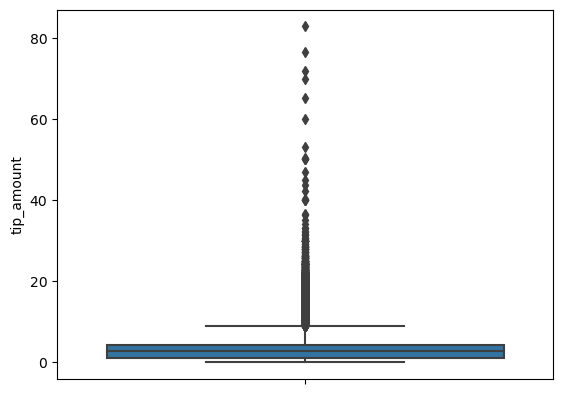

In [126]:
sns.boxplot(y='tip_amount', data=train_df, hue='Airport_fee')

C'est dommage car on semble voir une claire différence entre ceux payant les frais d'aéroport et ne les payant pas
Difficile de montrer une différence statistique car 92% ne payent pas d'Airport fee
On souhaitait faire un test statistiques type ANOVA mais une différence d'effectif et de moyenne trop importante

## Séparation des aéroports 

L'idée est de créer une variable in_airport proche d'un aéroport

In [135]:
# Coordonnées géographiques des 3 aéroports
airports = [(40.646985, -73.786530), (40.69183, -74.174002), (40.774376, -73.873628)]


def is_airport(row):
    for airport in airports:
        lat, lon = airport
        if (lat - 2*0.0005 <= row['PU_location_lat'] <= lat + 2*0.0005 and
            lon - 2*0.0005 <= row['PU_location_lon'] <= lon + 2*0.0005) or (
            lat - 2*0.0005 <= row['DO_location_lat'] <= lat + 2*0.0005 and
            lon - 2*0.0005 <= row['DO_location_lon'] <= lon + 2*0.0005):
            return 1
    return 0

train_df['airport'] = train_df.apply(is_airport, axis=1)

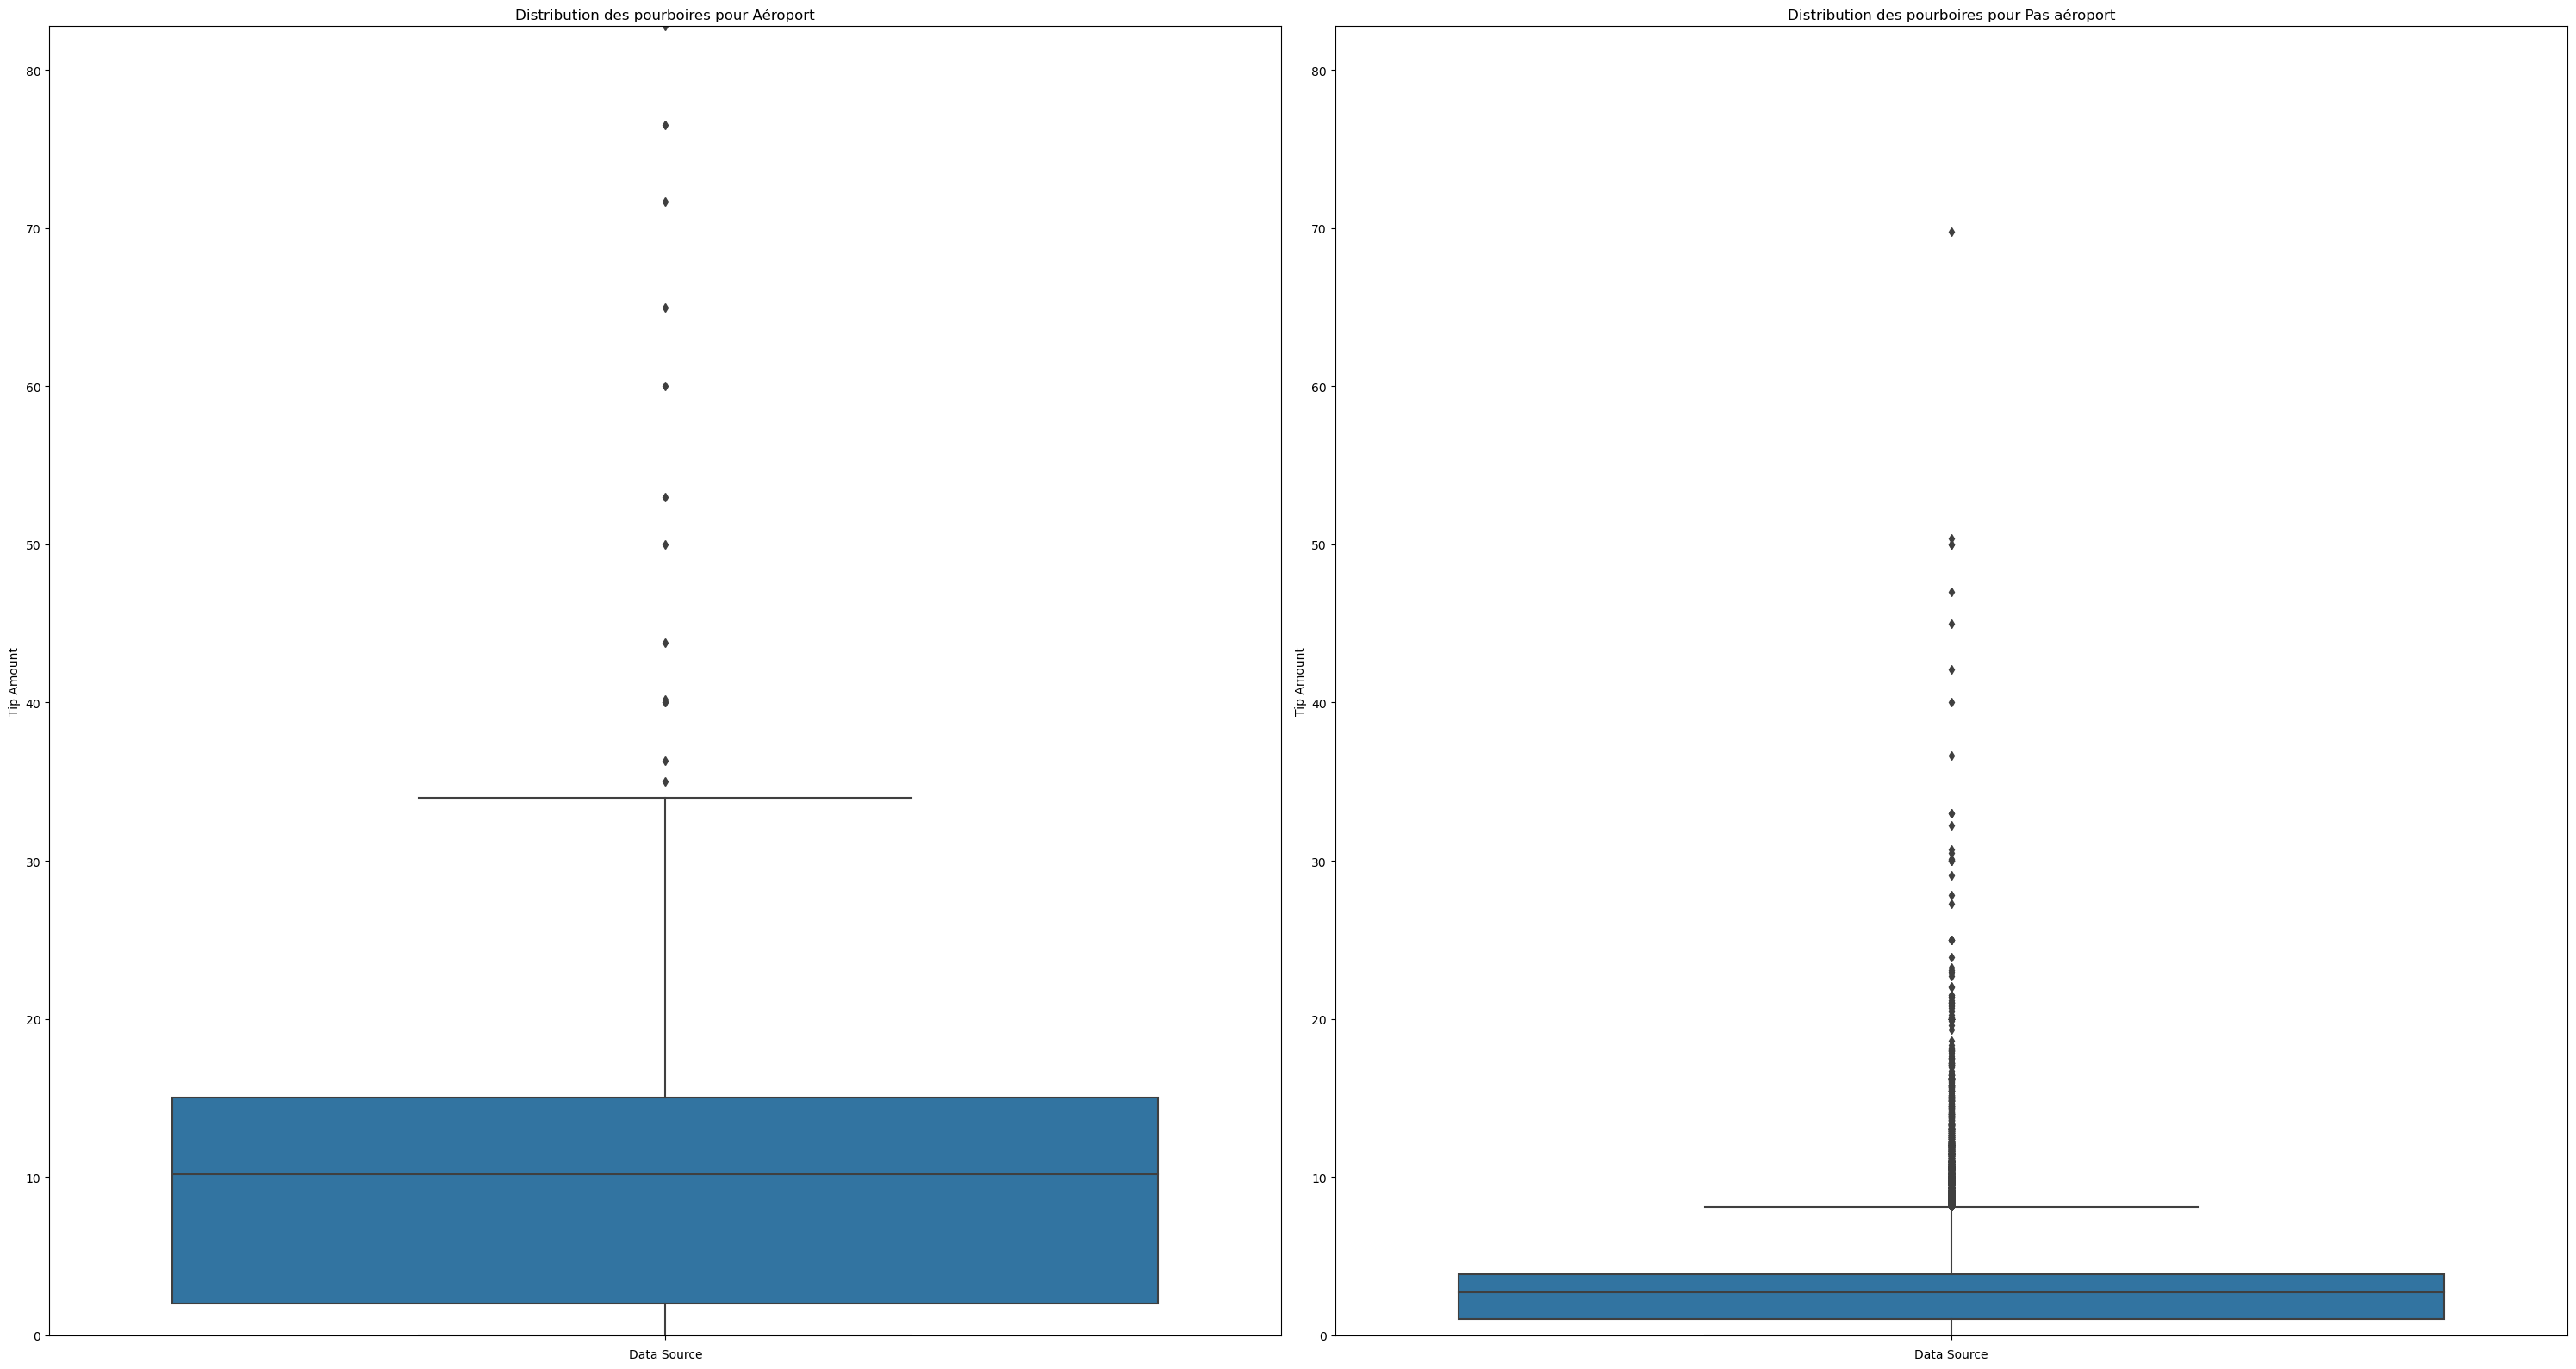

In [136]:
airport_trajet=train_df[train_df['airport']==1]
no_airport_trajet=train_df[train_df['airport']==0]


fig, axes = plt.subplots(1, 2, figsize=(30, 16))
axes = axes.flatten()


data_cmp = [airport_trajet,no_airport_trajet,train_df]

for i, ax in enumerate(axes):
    sns.boxplot(y='tip_amount', data=data_cmp[i], ax=ax)
    ax.set_title('Distribution des pourboires pour ' + (['Aéroport', 'Pas aéroport'][i]))
    ax.set_ylabel('Tip Amount')
    ax.set_xlabel('Data Source')


y_min = min(data_cmp[1]['tip_amount'].min(), data_cmp[0]['tip_amount'].min())
y_max = max(data_cmp[1]['tip_amount'].max(), data_cmp[0]['tip_amount'].max())
for ax in axes:
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

In [137]:
train_df['tip_per_km'] = train_df['tip_amount']/train_df['trip_distance']

In [139]:
print(train_df[train_df['airport']==0]['tip_per_km'].mean())

print(train_df[train_df['airport']==1]['tip_per_km'].mean())


1.866983121921042
0.7338051515233219


On observe l'inverse de ce qu'on voulait. Le prix moyen par km des trajets hors aéroports semblent moins élevés. On décide donc d'abandonner cette variable `airport`. En revanche, cela met en lumière que les lieux historiques et monuments sont très demandés lors des trajets en taxi notamment dans le quartier de Manhattan. Jetons un oeil sur les 10 endroits conocernés par les dropoff.

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import geodatasets


do_all = X_test[['DO_location_lat', 'DO_location_lon']]


geometry_do_all = [Point(xy) for xy in zip(do_all['DO_location_lon'], do_all['DO_location_lat'])]
gdf_test_do_all = gpd.GeoDataFrame(do_all, geometry=geometry_do_all, crs="EPSG:4326")


boros = gpd.read_file(geodatasets.get_path("nybb"))
boros = boros.to_crs("EPSG:4326")  

In [ ]:
#On a remarqué que y a beaucoup de drop-off à Manhattan dans le top des dropoff les plus fréquentés du X_test


top10_counts = gdf_test_do_all['geometry'].value_counts().head(10)
top10_points = gdf_test_do_all[gdf_test_do_all['geometry'].isin(top10_counts.index)]

boro_locations = boros.copy()
boro_locations['geometry'] = boros.centroid  


fig, ax = plt.subplots(1, 2, figsize=(15, 7))

boros.plot(ax=ax[0], color="white", edgecolor="black")
boro_locations.plot(ax=ax[0], color="red", marker="o")
top10_points.plot(ax=ax[0], color="blue", marker="o", alpha=0.6)
ax[0].set_title("Les quartiers de New York et le Top 10 des Drop-off Locations les plus fréquentés dans les données de test ") #
"""
# Second plot : les 10 points les plus fréquents
boros.plot(ax=ax[0], color="white", edgecolor="black")

ax[1].set_title("")

#
"""
plt.tight_layout()

plt.show()

In [ ]:
# Jetons un oeil sur les 10 endroits les conocernés par les pickup
pu_all = X_test[['PU_location_lat', 'PU_location_lon']]
geometry_pu_all = [Point(xy) for xy in zip(pu_all['PU_location_lon'], pu_all['PU_location_lat'])]
gdf_test_pu_all = gpd.GeoDataFrame(pu_all, geometry=geometry_pu_all, crs="EPSG:4326")

# Compter les 10 valeurs les plus fréquentes
top10_counts = gdf_test_pu_all['geometry'].value_counts().head(10)

In [ ]:
top10_points = gdf_test_pu_all[gdf_test_pu_all['geometry'].isin(top10_counts.index)]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

boros.plot(ax=ax[0], color="white", edgecolor="black")
boro_locations.plot(ax=ax[0], color="red", marker="o")
top10_points.plot(ax=ax[0], color="blue", marker="o", alpha=0.6)
ax[0].set_title("Les quartiers de New York et le Top 10 des Pickup Locations les plus fréquentés dans les données de test") #

plt.tight_layout()
plt.show()

#Manhattan, JFK et La Guardia Airport

In [ ]:
#Manhattan limites [(40.7,-74.12),(40.83,-73.95)]

In [ ]:
#Beaucoup de points drop-off à Manhattan et c'est dans la congestion zone 
#Sont-ils associés à des pourboires plus élevés
#Calculons le tip par km

#Montrer qu'ils ont des tips plus éleves en créant une colonne 'dropoff_Manhattan'


from geodatasets import get_path
path_to_file = get_path('nybb')


new_york_boroughs = gpd.read_file(path_to_file)  # exemple de dataset inclus avec geopandas
manhattan = new_york_boroughs[new_york_boroughs['BoroName'] == 'Manhattan']

In [140]:
# Définir les limites approximatives de Manhattan
min_lat, max_lat = 40.7, 40.83
min_lon, max_lon = -74.12, -73.95

# Création des colonnes pour indiquer si la prise en charge et la dépose sont dans Manhattan
train_df['PU_in_manhattan'] = train_df.apply(
    lambda row: int(min_lat <= row['PU_location_lat'] <= max_lat and min_lon <= row['PU_location_lon'] <= max_lon), axis=1
)
train_df['DO_in_manhattan'] = train_df.apply(
    lambda row: int(min_lat <= row['DO_location_lat'] <= max_lat and min_lon <= row['DO_location_lon'] <= max_lon), axis=1
)

In [141]:
train_df['in_manhattan']=train_df['PU_in_manhattan']*train_df['DO_in_manhattan']

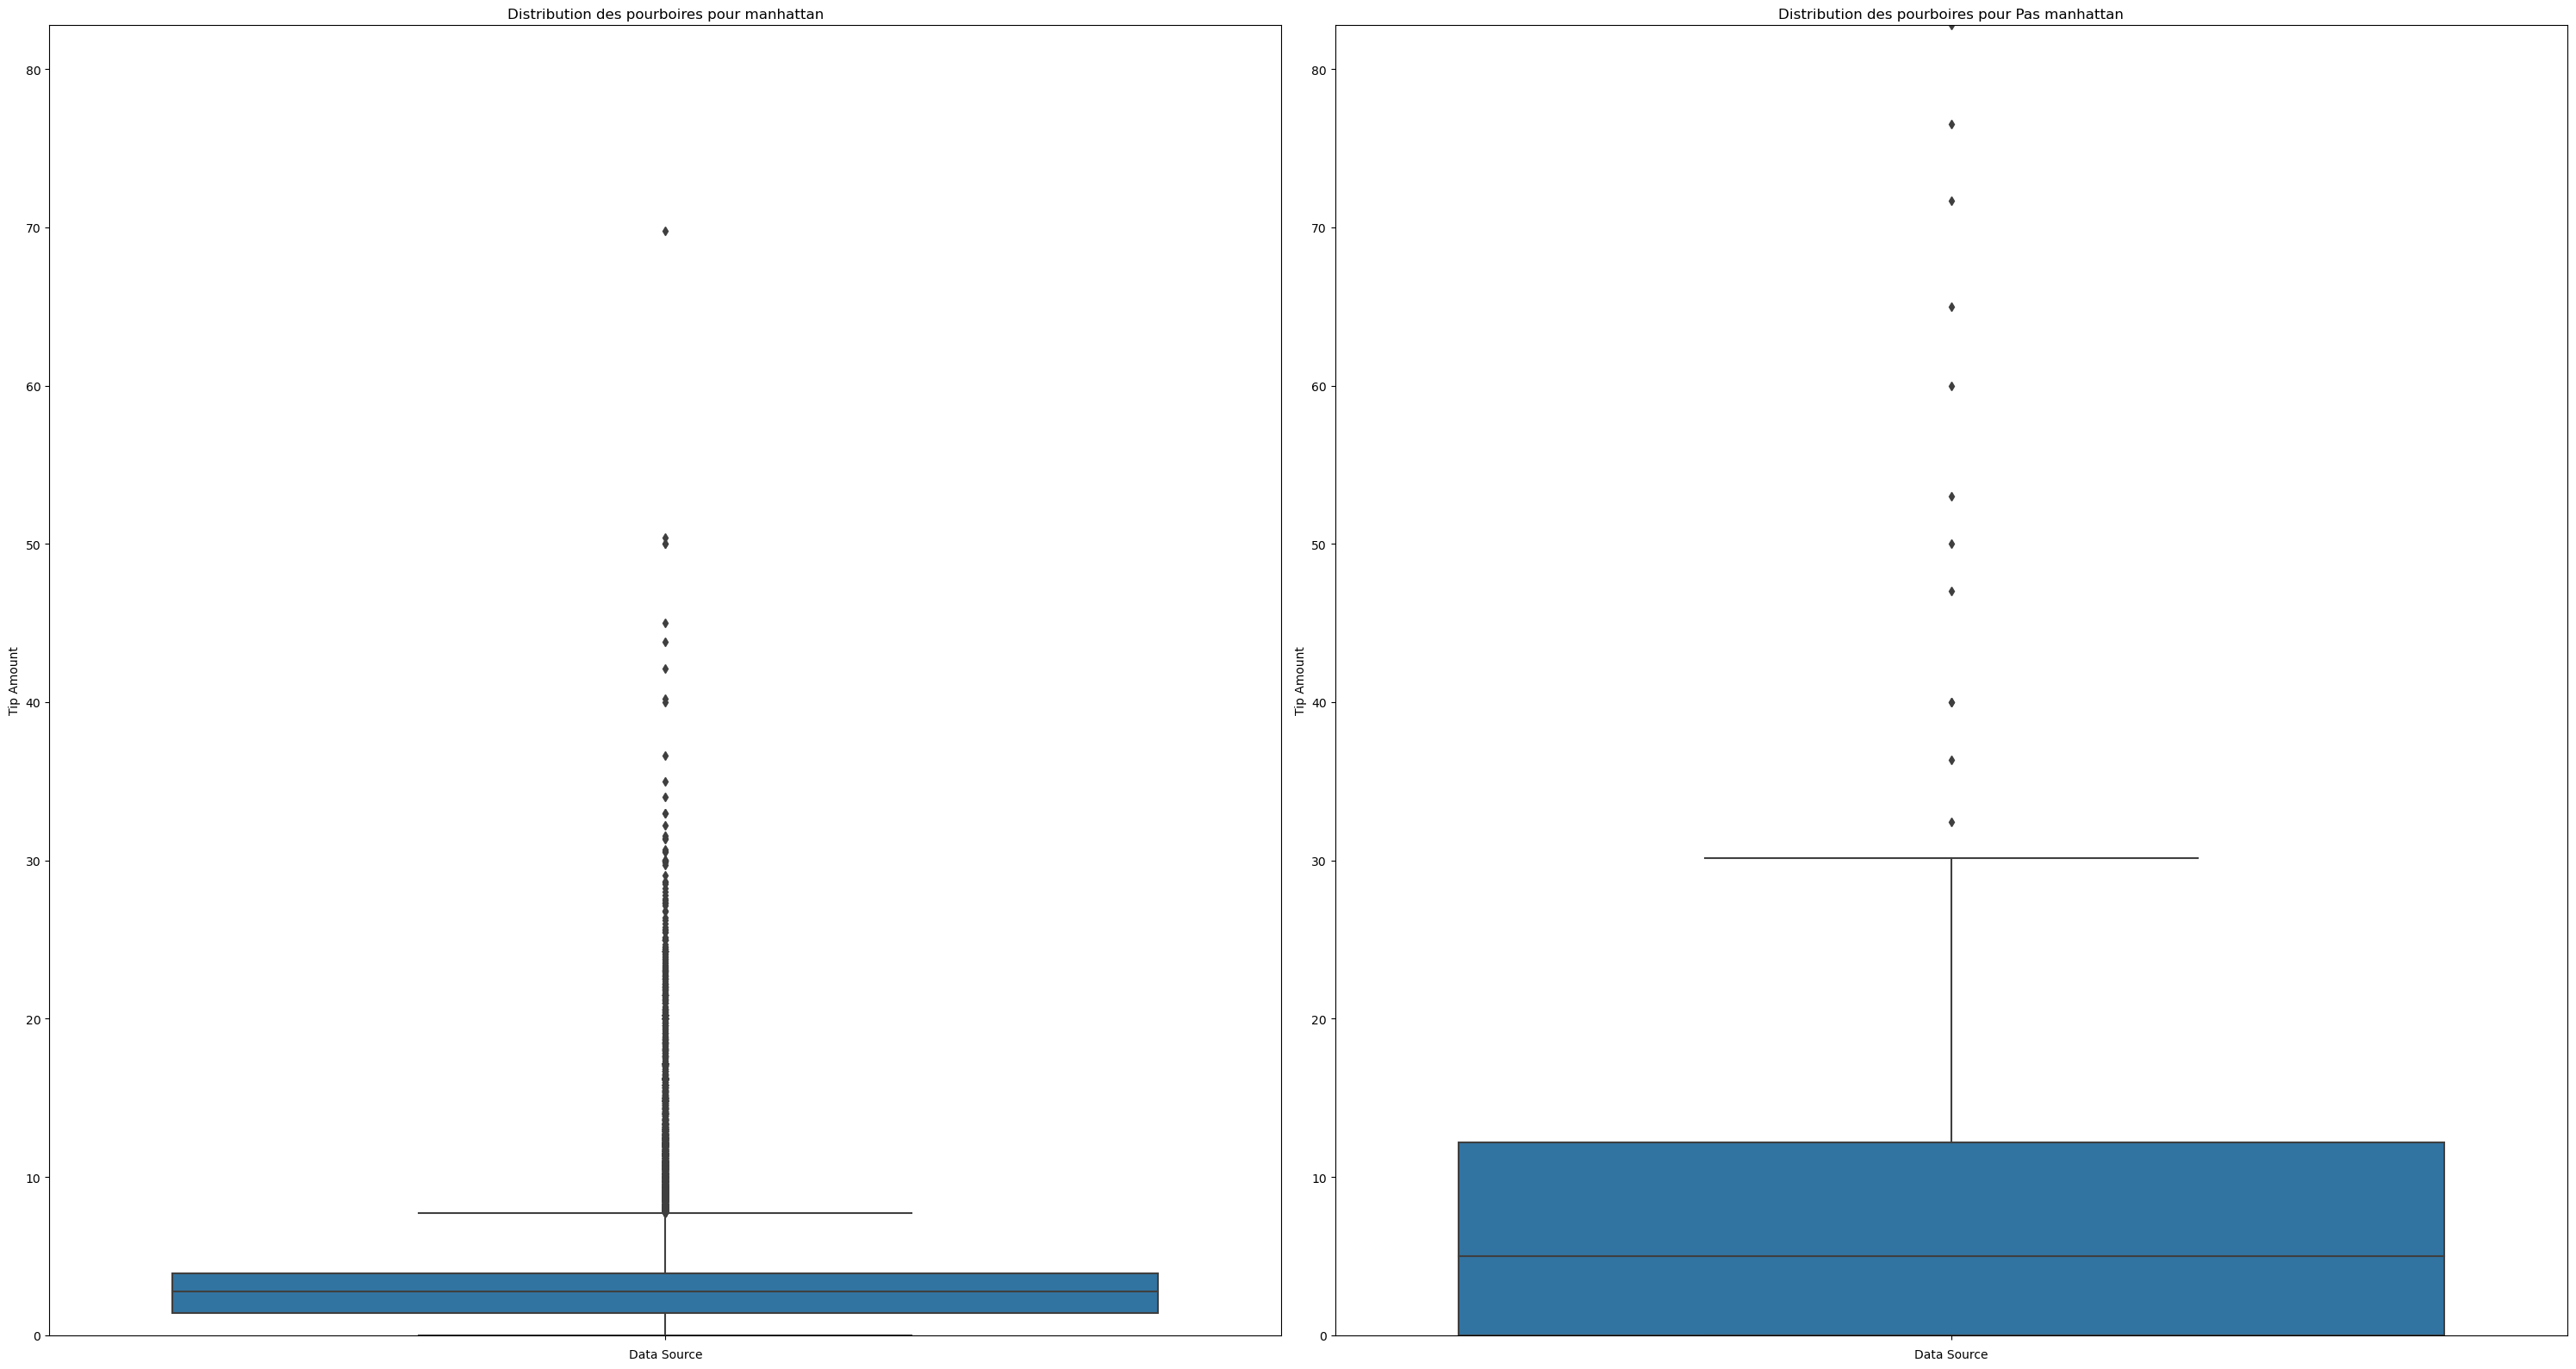

In [143]:

manhattan_trajet=train_df[train_df['PU_in_manhattan']==1]
no_manhattan_trajet=train_df[train_df['PU_in_manhattan']==0]

# Supposons que JFK et train_df sont déjà définis
fig, axes = plt.subplots(1, 2, figsize=(30, 16))
axes = axes.flatten()

# Liste des DataFrames à comparer
data_cmp = [manhattan_trajet,no_manhattan_trajet,train_df]

# Créer des boxplots pour chaque DataFrame
for i, ax in enumerate(axes):
    sns.boxplot(y='tip_amount', data=data_cmp[i], ax=ax)
    ax.set_title('Distribution des pourboires pour ' + (['manhattan', 'Pas manhattan'][i]))
    ax.set_ylabel('Tip Amount')
    ax.set_xlabel('Data Source')

# Définir des limites communes pour l'axe des ordonnées
y_min = min(data_cmp[1]['tip_amount'].min(), data_cmp[0]['tip_amount'].min())
y_max = max(data_cmp[1]['tip_amount'].max(), data_cmp[0]['tip_amount'].max())
for ax in axes:
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

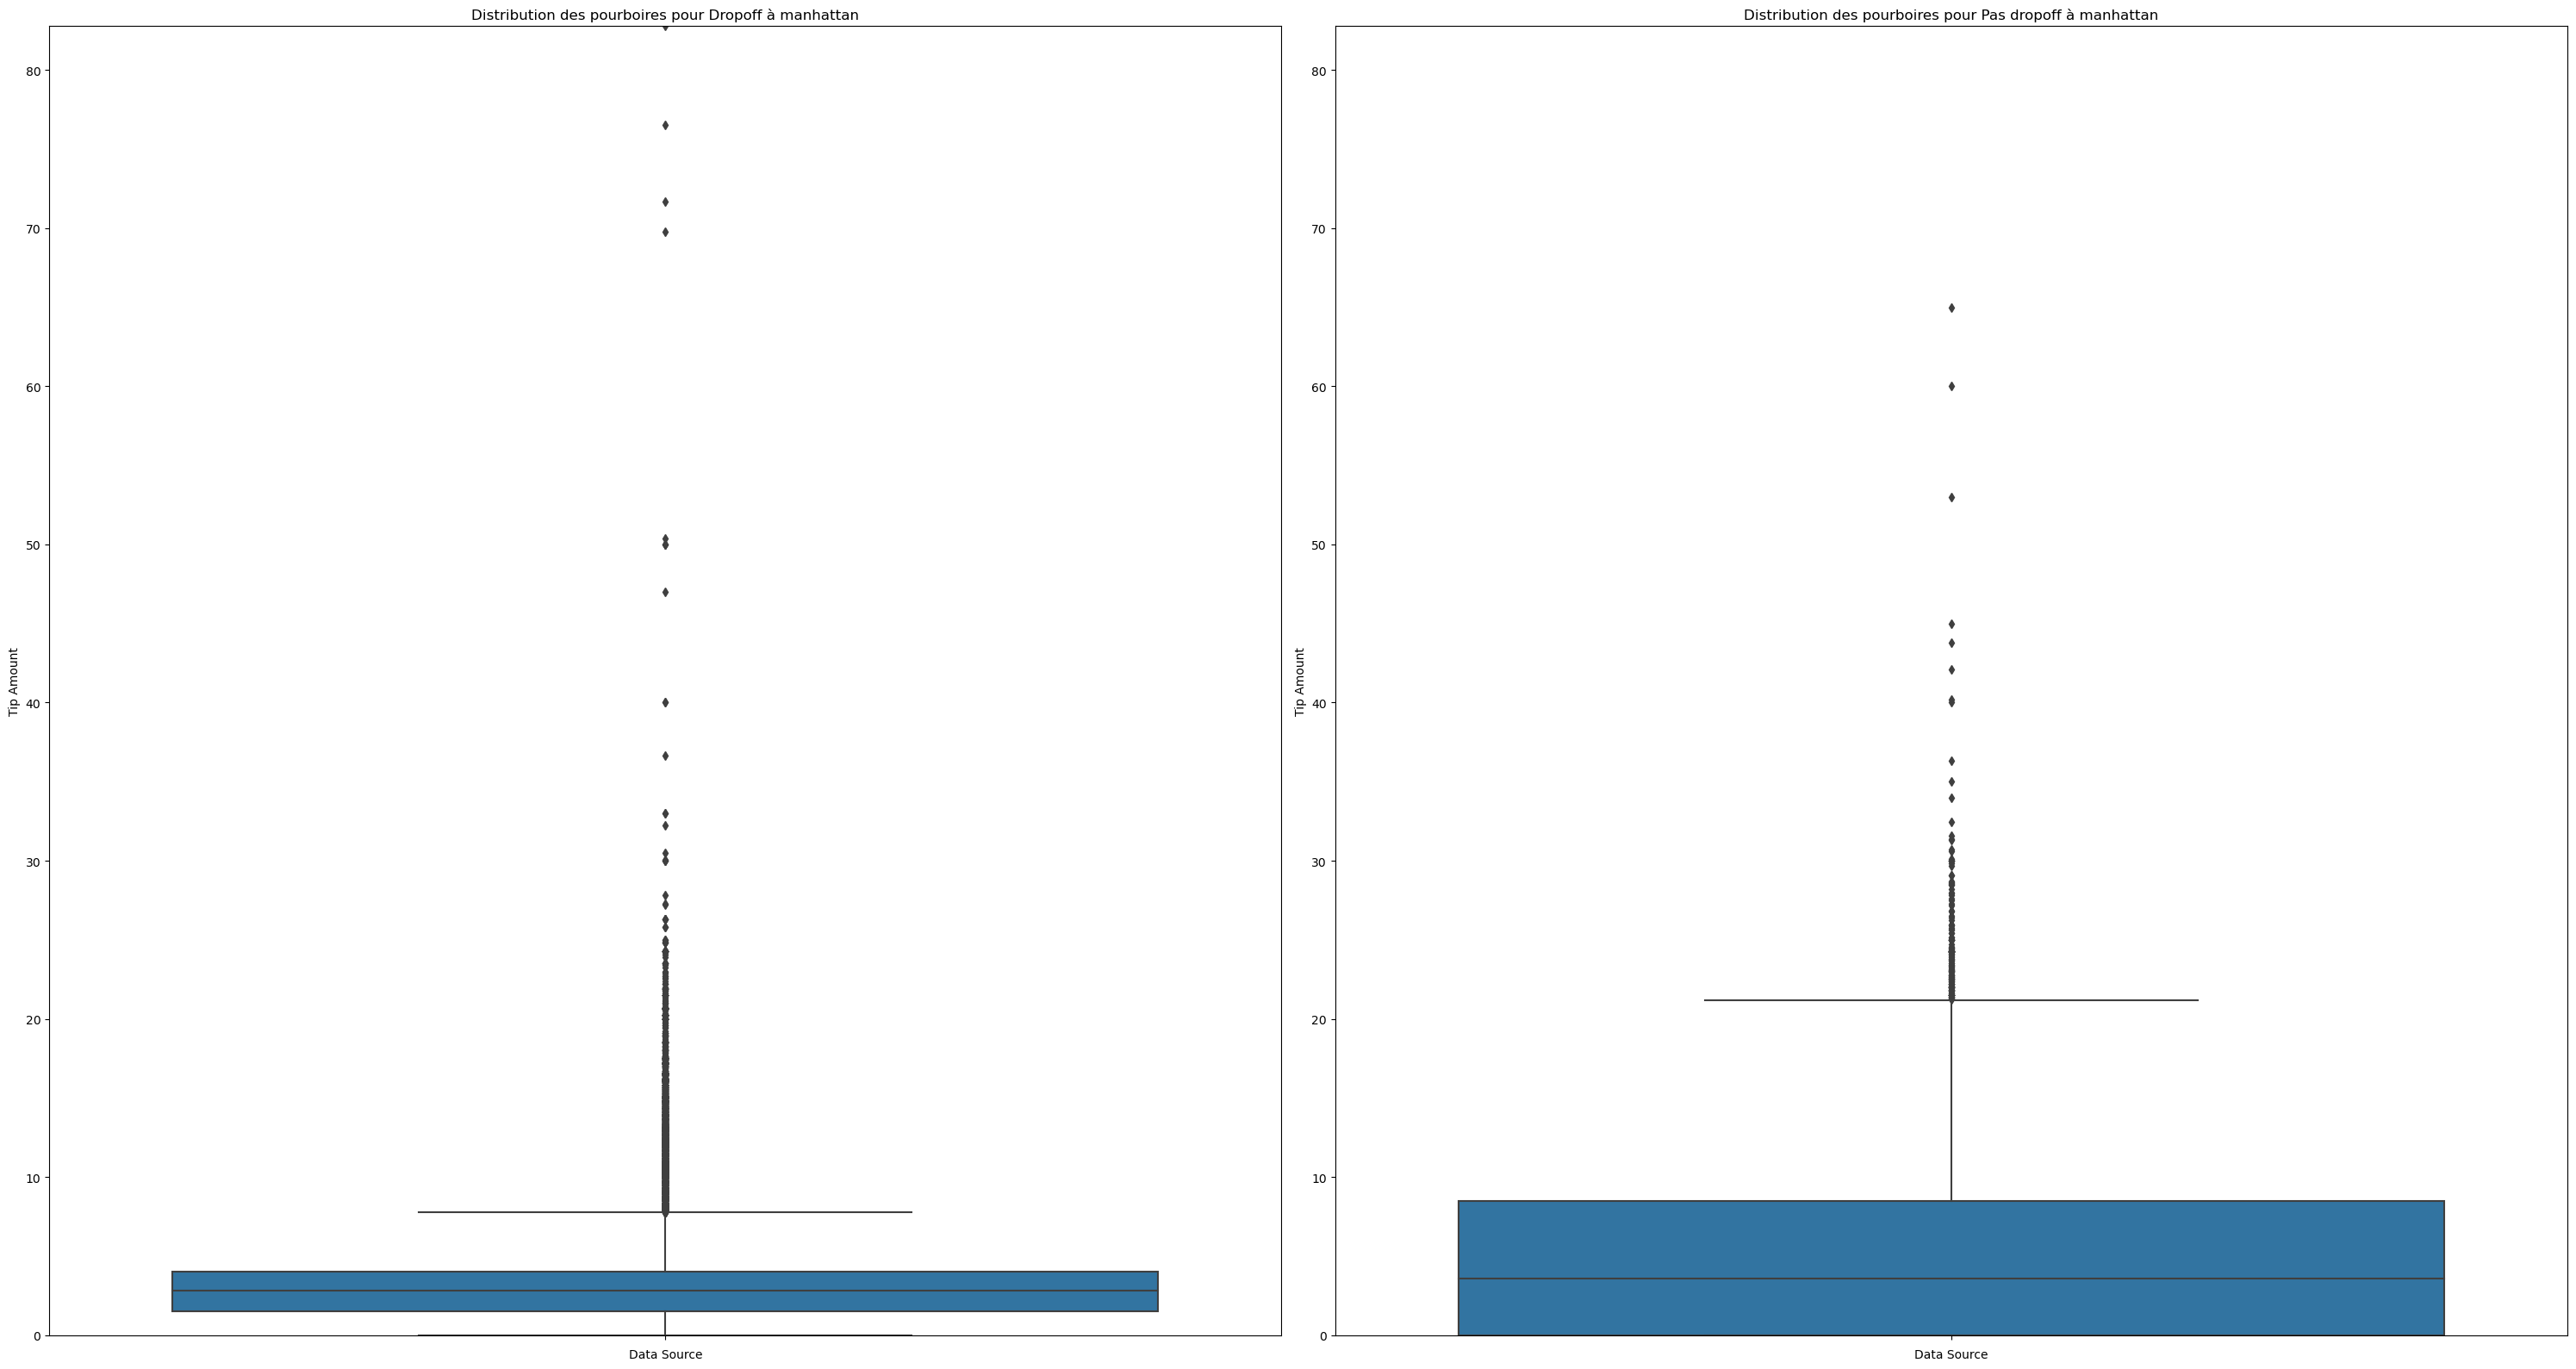

In [144]:
manhattan_trajet=train_df[train_df['DO_in_manhattan']==1]
no_manhattan_trajet=train_df[train_df['DO_in_manhattan']==0]


fig, axes = plt.subplots(1, 2, figsize=(30, 16))
axes = axes.flatten()

# Liste des DataFrames à comparer
data_cmp = [manhattan_trajet,no_manhattan_trajet,train_df]

# Créer des boxplots pour chaque DataFrame
for i, ax in enumerate(axes):
    sns.boxplot(y='tip_amount', data=data_cmp[i], ax=ax)
    ax.set_title('Distribution des pourboires pour ' + (['Dropoff à manhattan', 'Pas dropoff à manhattan'][i]))
    ax.set_ylabel('Tip Amount')
    ax.set_xlabel('Data Source')

# Définir des limites communes pour l'axe des ordonnées
y_min = min(data_cmp[1]['tip_amount'].min(), data_cmp[0]['tip_amount'].min())
y_max = max(data_cmp[1]['tip_amount'].max(), data_cmp[0]['tip_amount'].max())
for ax in axes:
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# Sauvegarde des fichiers train et test nettoyés

In [ ]:
train_df.to_csv(_REP_PATH_+'/data/train_nettoye.csv') 
test_df.to_csv(_REP_PATH_+'/data/test_nettoye.csv') 